<font size=10 color=gold> Going for Gold: </font> <br> <font size=6>What really influences a country’s performance at the Olympic Games?</font>
---
---

In [1]:
# In case you have never used this API
!pip install gmaps
print('-'*1000)
!pip install googlemaps

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [51]:
# Dependencies
import requests, warnings, googlemaps, gmaps, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from api_keys import gkey, aqikey # will need to create your own key file
warnings.filterwarnings('ignore')

Please note that to run this notebook you will need your own API keys for [Google Maps](https://developers.google.com/maps/documentation/embed/get-api-key) and [Air Quality Index](https://aqicn.org/json-api/doc/)

# 1. Initial Data Cleanup & Manipulation
Over the course of this Notebook, we will be using 7 different data sets in total, but here we are just focusing on cleaning the first 2 as they will be used throughout every section of our analysis. From here on out any further data cleaning will be performed at the begining of the subsection. 

---
## 1.1 Cleaning the Olympics Data

In [27]:
# Reference path to raw data CSV 
csv_path = '0_raw_data/athlete_events.csv'
# Read CSV into Pandas DataFrame
raw_olympics_df = pd.read_csv(csv_path)
# Check out what we have
raw_olympics_df.head(3)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN


In [28]:
# Reference path to raw data CSV 
csv_path = '0_raw_data/noc_regions.csv'

# Read CSV into Pandas DataFrame
raw_NOC_df = pd.read_csv(csv_path)

# And again, check out what we have
raw_NOC_df.tail(15)

,NOC,region,notes
215,URU,Uruguay,NaN
216,USA,USA,NaN
217,UZB,Uzbekistan,NaN
218,VAN,Vanuatu,NaN
219,VEN,Venezuela,NaN
220,VIE,Vietnam,NaN
221,VIN,Saint Vincent,NaN
222,VNM,Vietnam,NaN
223,WIF,Trinidad,West Indies Federation
224,YAR,Yemen,North Yemen


In [29]:
# Notice that USA does not have it's full name in the Region column. 
# We will need to fix that, along with the UK, because most of our other data will call to the countries' full names

# First we must make NOC the index
NOC_df = raw_NOC_df.set_index('NOC')

# We then replace those regions with the full country names
NOC_df.loc['USA','region'] = 'United States of America'
NOC_df.loc['GBR','region'] = 'United Kingdom'

In [30]:
# Now we want to drop the unnecessary 'notes' column
NOC_df = NOC_df.drop(columns=['notes'])
# And reset the Index before we merge 
NOC_df = NOC_df.reset_index()

In [31]:
# Merging the region's into the olympics df
olympics_df = pd.merge(raw_olympics_df, NOC_df, how='left', on='NOC')
# Sorting by year
olympics_df = olympics_df.sort_values('Year')
# Capitolize the region column
olympics_df = olympics_df.rename(columns={'region':'Region'})
# Reset the index
olympics_df = olympics_df.reset_index(drop=True)

# Move the Region column towards the front and drop any unnecessary columns:
#  - ID (because we'll simply call athletes by their name)
#  - Team (because we care only about each country, not their special name)
#  - NOC (because they change over time more than the country name under 'Region' does)
#  - Games (because its information is contaned in the Year & Season columns)
olympics_df = olympics_df[[
 'Name',
 'Region',
 'Sex',
 'Age',
 'Height',
 'Weight',
 'Medal',
 'Sport',
 'Event',
 'Year',
 'Season',
 'City']]

# Let's take a look at our final product
olympics_df.head(3)

,Name,Region,Sex,Age,Height,Weight,Medal,Sport,Event,Year,Season,City
0,Fritz Richard Gustav Schuft,Germany,M,19.0,NaN,NaN,NaN,Gymnastics,Gymnastics Men's Pommelled Horse,1896,Summer,Athina
1,Pierre Alexandre Tuffri,France,M,19.0,NaN,NaN,Silver,Athletics,Athletics Men's Triple Jump,1896,Summer,Athina
2,Pierre Alexandre Tuffri,France,M,19.0,NaN,NaN,NaN,Athletics,Athletics Men's Long Jump,1896,Summer,Athina


In [13]:
# Output our new df as a CSV in case anyone want's to use it on its own
output_path = '1_clean_data/olympics_df.csv'
olympics_df.to_csv(output_path, index=False)

---
## 1.2 Data Manipulation <br> <font size=2 color=lightgrey>by Warren</font>

####  Recent Olympics Data

In [32]:
# Dropping some things we wont need
slim_olympics_df = olympics_df.drop(['Height', 'Weight', 'City'],1)
# and collecting only the two most recent Olympics
recent_olympics_df = slim_olympics_df.loc[olympics_df.Year >= 2010]
# and finally only counting the countries who medalled
medalled_recent_df = recent_olympics_df.loc[
    (recent_olympics_df.Medal == 'Bronze') | 
    (recent_olympics_df.Medal == 'Silver') | 
    (recent_olympics_df.Medal == 'Gold')]

medalled_recent_df.count()

Name      5081
Region    5076
Sex       5081
Age       5081
Medal     5081
Sport     5081
Event     5081
Year      5081
Season    5081
dtype: int64

In [33]:
# Notice that we have one Region missing, let's find it
missing_their_country = medalled_recent_df.loc[medalled_recent_df['Region'].isnull() == True]
missing_their_country

,Name,Region,Sex,Age,Medal,Sport,Event,Year,Season
242124,Wang Jue Gu,NaN,F,32.0,Bronze,Table Tennis,Table Tennis Women's Team,2012,Summer
244344,Li Jia Wei,NaN,F,30.0,Bronze,Table Tennis,Table Tennis Women's Team,2012,Summer
250007,Feng Tian Wei,NaN,F,25.0,Bronze,Table Tennis,Table Tennis Women's Singles,2012,Summer
250009,Feng Tian Wei,NaN,F,25.0,Bronze,Table Tennis,Table Tennis Women's Team,2012,Summer
263846,Joseph Isaac Schooling,NaN,M,21.0,Gold,Swimming,Swimming Men's 100 metres Butterfly,2016,Summer


In [35]:
# A quick google search shows that all of these athletes competed for Singapore
for index in list(missing_their_country.index):
    medalled_recent_df.set_value(index, 'Region', 'Singapore')

# check
medalled_recent_df.loc[250007]

Name                     Feng Tian Wei
Region                       Singapore
Sex                                  F
Age                                 25
Medal                           Bronze
Sport                     Table Tennis
Event     Table Tennis Women's Singles
Year                              2012
Season                          Summer
Name: 250007, dtype: object

####  Gender Separation

In [36]:
# Here we will seporate our medalled athletes by gender
female_medalled_recent_df = medalled_recent_df.loc[
    medalled_recent_df.Sex == 'F']
male_medalled_recent_df = medalled_recent_df.loc[
    medalled_recent_df.Sex == 'M']

# Then group by region because we will want total medal counts per gender
female_medalled_groupedby_region = female_medalled_recent_df.groupby('Region')
male_medalled_groupedby_region = male_medalled_recent_df.groupby('Region')

# Merge the two together into a df
gender_medalled_df = pd.merge(
    female_medalled_groupedby_region.Medal.count(), 
    male_medalled_groupedby_region.Medal.count(), 
    on='Region', how='outer', suffixes=['_Females', '_Males'])

gender_medalled_df

,Medal_Females,Medal_Males
Region,,
Argentina,17.0,24.0
Armenia,1.0,6.0
Australia,108.0,94.0
Austria,15.0,40.0
Azerbaijan,6.0,22.0
...,...,...
Trinidad,NaN,11.0
Uganda,NaN,1.0
United Arab Emirates,NaN,1.0


In [37]:
# Many countries have never seen their females bring home a medal, 
#  so we will need to fill those np.nan values
gender_medalled_df = gender_medalled_df.fillna(0)

# Create a column with total medal count as well
gender_medalled_df['Medal_Total'] = gender_medalled_df.Medal_Males + gender_medalled_df.Medal_Females

# And finally, two columns with the percent of the country's medals won by males and females
gender_medalled_df['Percent_Female'] = round(
    100*gender_medalled_df.Medal_Females / (gender_medalled_df.Medal_Males + gender_medalled_df.Medal_Females),2)
gender_medalled_df['Percent_Male'] = round(
    100*gender_medalled_df.Medal_Males / (gender_medalled_df.Medal_Males + gender_medalled_df.Medal_Females),2)

gender_medalled_df

,Medal_Females,Medal_Males,Medal_Total,Percent_Female,Percent_Male
Region,,,,,
Argentina,17.0,24.0,41.0,41.46,58.54
Armenia,1.0,6.0,7.0,14.29,85.71
Australia,108.0,94.0,202.0,53.47,46.53
Austria,15.0,40.0,55.0,27.27,72.73
Azerbaijan,6.0,22.0,28.0,21.43,78.57
...,...,...,...,...,...
Trinidad,0.0,11.0,11.0,0.00,100.00
Uganda,0.0,1.0,1.0,0.00,100.00
United Arab Emirates,0.0,1.0,1.0,0.00,100.00


# 2. How do countries fare historically?

---
## 2.1 Overall Performance <br> <font size=2 color=lightgrey>by Shashank</font>

#### Data Manipulation

In [38]:
# Add 3 medal columns for Gold, Silver, and Bronze...

olympicsMedals=olympics_df
olympicsMedals["Gold"]=[1 if x=="Gold" else 0 for x in olympicsMedals.Medal]
olympicsMedals["Silver"]=[1 if x=="Silver" else 0 for x in olympicsMedals.Medal]
olympicsMedals["Bronze"]=[1 if x=="Bronze" else 0 for x in olympicsMedals.Medal]

# ...and 1 extra medal column that can be counted later
olympicsMedals["MedalCount"]=[0 if pd.isnull(x) else 1 for x in olympics_df.Medal]

olympicsMedals.head(3)

,Name,Region,Sex,Age,Height,Weight,Medal,Sport,Event,Year,Season,City,Gold,Silver,Bronze,MedalCount
0,Fritz Richard Gustav Schuft,Germany,M,19.0,NaN,NaN,NaN,Gymnastics,Gymnastics Men's Pommelled Horse,1896,Summer,Athina,0,0,0,0
1,Pierre Alexandre Tuffri,France,M,19.0,NaN,NaN,Silver,Athletics,Athletics Men's Triple Jump,1896,Summer,Athina,0,1,0,1
2,Pierre Alexandre Tuffri,France,M,19.0,NaN,NaN,NaN,Athletics,Athletics Men's Long Jump,1896,Summer,Athina,0,0,0,0


In [41]:
# Groupby on countries, sum up the medals and put that in a new dataframe.

countrygroup=olympicsMedals[["Region", 
                             "MedalCount", 
                             "Gold", 
                             "Silver", 
                             "Bronze"]].groupby(by="Region")

countryMedalTally=pd.DataFrame(countrygroup.sum().sort_values(by="MedalCount",ascending=False)).reset_index()

countryMedalTally.to_csv("1_clean_data/countryMedalTally.csv",index=False)

countryMedalTally.head()

,Region,MedalCount,Gold,Silver,Bronze
0,United States of America,5637,2638,1641,1358
1,Russia,3947,1599,1170,1178
2,Germany,3756,1301,1195,1260
3,United Kingdom,2068,678,739,651
4,France,1777,501,610,666


#### Medal Counts by Country

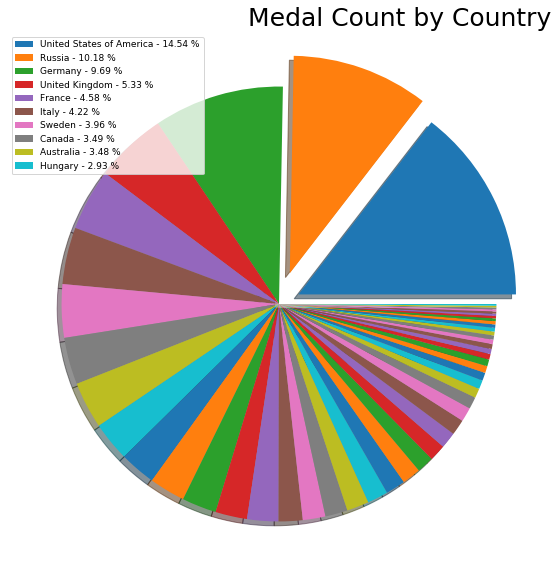

In [44]:
# Pie chart of the total medals tally
values = countryMedalTally.iloc[0:50,]["MedalCount"]
labels = countryMedalTally.iloc[0:50,]["Region"]
percents = 100*values/values.sum()
labels_percents = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels,percents)]

# Creating the explode to emphasize the US and Russia
explode = [0,]*len(labels)
explode[0]=0.1
explode[1]=0.15

plt.figure(figsize=(15,10))
plt.pie(values, labels=None, explode=explode, shadow=True)
plt.title("Medal Count by Country", fontsize=25, loc='right')
plt.legend(labels=labels_percents[:10], fontsize=9, loc='upper left')

plt.savefig("2_plots/1 - Country Share of all Medals.png")

plt.show()

Here we see that the United States and Russia have won nearly a quarter of all Olympic medals, and astonishing amount when you consider that Russia didn't compete in the Olympics for three decades following WWI and both countries have boycotted the Olympics at different time in the 80s

---

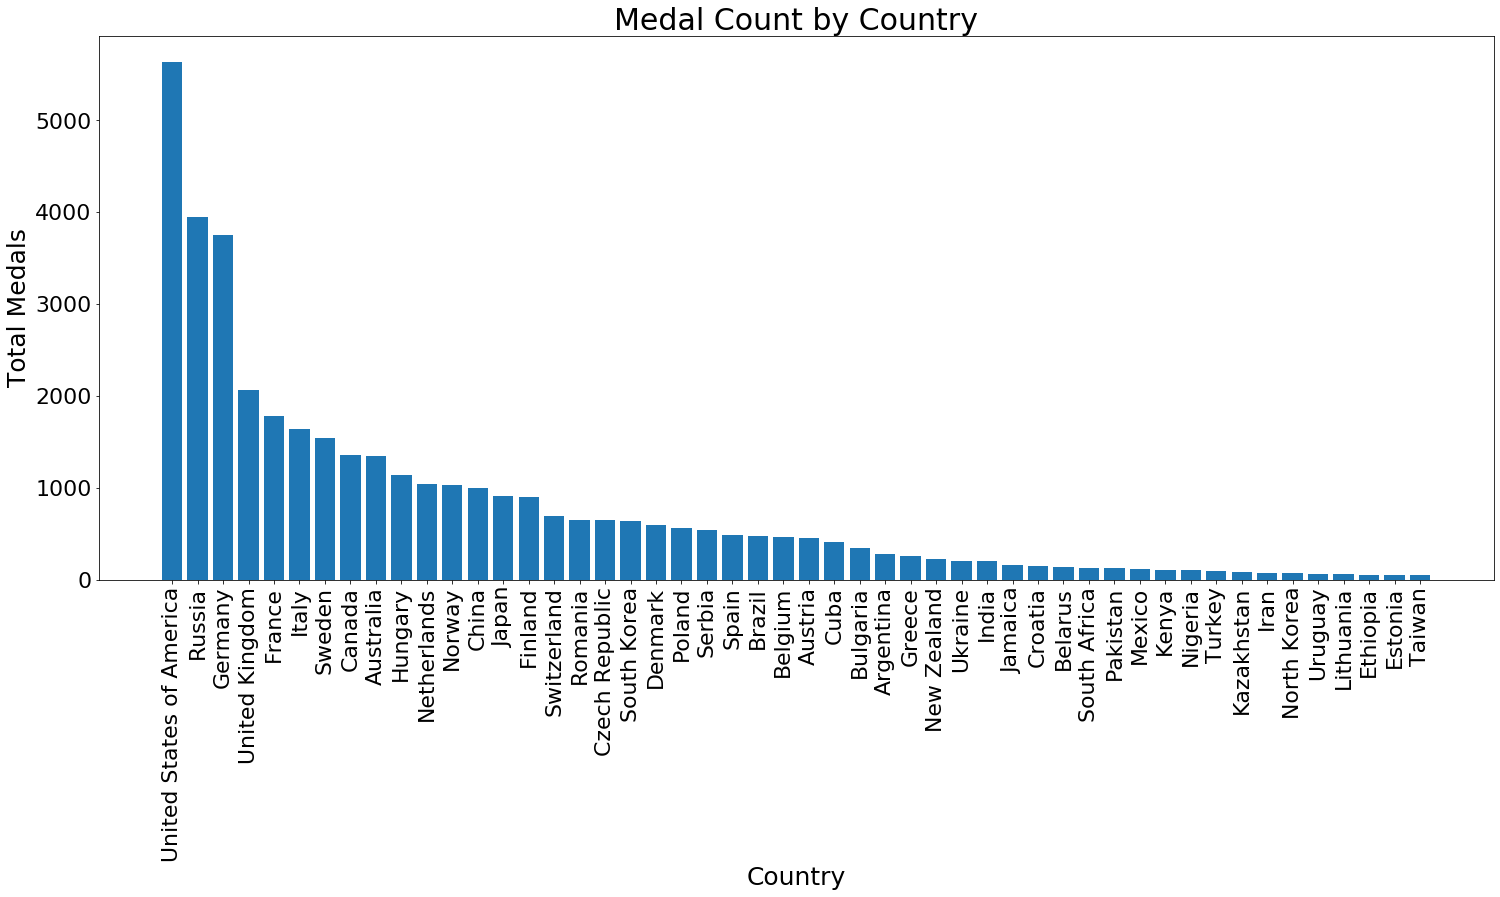

In [45]:
# If we would like to see all countries, here is a bar chart of total medals tally

x_values=countryMedalTally.iloc[0:50,]["Region"]
y_values=countryMedalTally.iloc[0:50,]["MedalCount"]

plt.figure(figsize=(25,10))
plt.bar(x_values,y_values)
plt.title("Medal Count by Country", fontsize=30)
plt.xlabel("Country", fontsize=25)
plt.ylabel("Total Medals", fontsize=25)
plt.xticks(rotation=90, fontsize=22)
plt.yticks(fontsize=22)

plt.show()

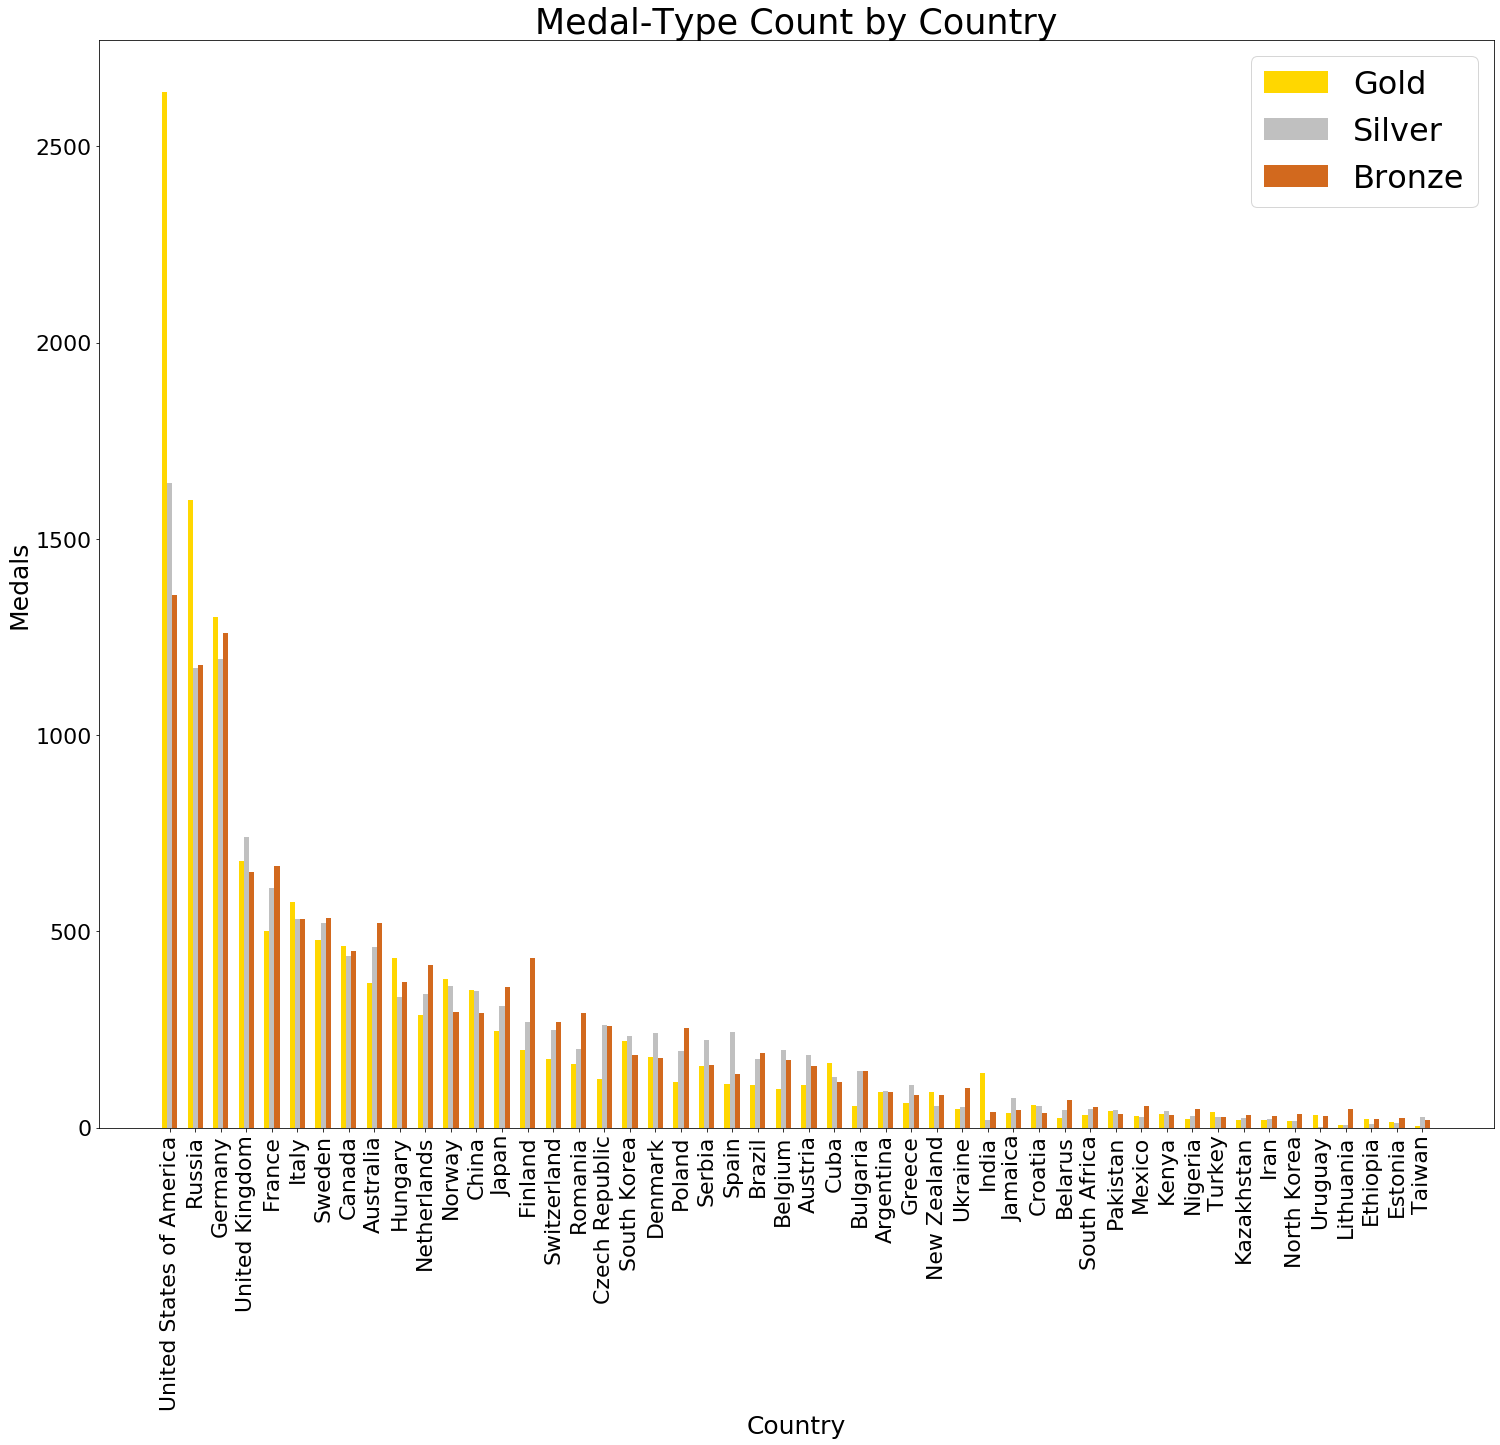

In [46]:
# Breakdown of Medals by Country

#define x-values as numbers from 0 to 49
labels=list(countryMedalTally.iloc[0:50,]["Region"])
x_values=np.arange(len(labels))

#define 3 y-values, 1 for each type of medal
y1_values=countryMedalTally.iloc[0:50,]["Gold"]
y2_values=countryMedalTally.iloc[0:50,]["Silver"]
y3_values=countryMedalTally.iloc[0:50,]["Bronze"]

#plot the 3 bars next to each other
fig = plt.figure(figsize=(25,20))
ax = fig.add_subplot(111)
golds=ax.bar(x_values-0.2,y1_values,color="gold",align="center",width=0.2,label="Gold")
silvers=ax.bar(x_values,y2_values,color="silver",align="center",width=0.2,label="Silver")
bronzes=ax.bar(x_values+0.2,y3_values,color="chocolate",align="center",width=0.2,label="Bronze")

#set overall labels for the X and Y axes
ax.set_ylabel("Medals", fontsize=25)
ax.set_xlabel("Country", fontsize=25)

#arrange xticks and give them country labels
ax.set_xticks(x_values)
ax.set_xticklabels(labels)

#add legend
ax.legend(fontsize=32)

#for the overall figure, add a title, rotate the xticks
plt.title("Medal-Type Count by Country", fontsize=35)
plt.xticks(rotation=90, fontsize=22)
plt.yticks(fontsize=22)

#save and show

plt.savefig("2_plots/2 - Performance by Medal-Type for Top 50 Countries.png")

plt.show()

#### Heatmap of Top Performing Countries

In [57]:
#find center lats and lngs for every country
countries=list(countryMedalTally["Region"])
center_lat=[None]*len(countries)
center_lng=[None]*len(countries)

gm = googlemaps.Client(key=gkey)

for i in range(len(countries)):
    try:
        geocode_result = gm.geocode(countries[i])[0]
        center_lat[i]=geocode_result['geometry']['location']['lat']
        center_lng[i]=geocode_result['geometry']['location']['lng']
    except:
        continue
### this cell will take ~30 seconds to complete ###

In [58]:
#re-assign NaN lats and lngs to 0s
for i in range(len(center_lat)):
    if pd.isnull(center_lat[i]):
        center_lat[i]=0
        center_lng[i]=0

In [59]:
#create locations dataframe for the gmaps heat layer
locations=pd.DataFrame({
    "Lat":center_lat,
    "Lng":center_lng
})

locations.head()

,Lat,Lng
0,37.090240,-95.712891
1,61.524010,105.318756
2,51.165691,10.451526
3,55.378051,-3.435973
4,46.227638,2.213749


In [90]:
#configure gmaps
gmaps.configure(api_key=gkey)

#calculate medal weights (using Time Mag's 4:2:1 weighting scale)
# and I've decided to use the square root of the weighted value as to diminish the outliers atop the leaderboard 
medalweights=list((4*countryMedalTally.Gold + 2*countryMedalTally.Silver + countryMedalTally.Bronze)**(1/2))

#add heat layer
fig=gmaps.figure(zoom_level=2,center=(20,0))
heat_layer=gmaps.heatmap_layer(locations, 
                               weights = medalweights,
                               dissipating=False,point_radius=6, max_intensity=100)
fig.add_layer(heat_layer)

#display
display(fig)

Figure(layout=FigureLayout(height='420px'))

---
## 2.2 Historical Performance by Country <br> <font size=2 color=lightgrey>by Amber</font>

#### Data Manipulation

In [91]:
# Let's look at just the top 10 regions' total medal counts
cleaned_byregion = olympicsMedals[['Region','MedalCount']]

cleaned_byregion = cleaned_byregion.groupby('Region').sum().sort_values('MedalCount',ascending = False)
top_ten_medalcounts = cleaned_byregion.iloc[0:10,].reset_index()
top_ten_regions = pd.DataFrame(top_ten_medalcounts['Region'])
top_ten_regions['Total Medal Count'] = countryMedalTally['MedalCount']
top_ten_regions

,Region,Total Medal Count
0,United States of America,5637
1,Russia,3947
2,Germany,3756
3,United Kingdom,2068
4,France,1777
5,Italy,1637
6,Sweden,1536
7,Canada,1352
8,Australia,1349
9,Hungary,1135


In [92]:
# Now we would like the total medal counts over time
overtime_byregion = olympicsMedals[['Region','Year','MedalCount']].reset_index(drop=True).dropna()
overtime_pivot = pd.pivot_table(overtime_byregion, values='MedalCount', index=['Region'],
                     columns=['Year'], aggfunc=np.sum,fill_value=0).reset_index()
medals_overtime = pd.merge(overtime_pivot, top_ten_regions, how='right', on='Region').set_index('Region')
medals_overtime = medals_overtime.sort_values(by='Total Medal Count', ascending=False)
del medals_overtime['Total Medal Count']
medals_overtime.head(3)

,1896,1900,1904,1906,1908,1912,1920,1924,1928,1932,...,1998,2000,2002,2004,2006,2008,2010,2012,2014,2016
Region,,,,,,,,,,,,,,,,,,,,,
United States of America,20,63,394,24,65,107,194,194,102,223,...,34,242,84,263,52,317,97,248,64,264
Russia,0,0,0,0,3,14,0,0,0,0,...,52,187,38,189,41,142,25,140,68,115
Germany,32,45,16,30,21,53,0,0,82,57,...,44,118,61,149,54,99,54,94,36,159


In [93]:
#create dict of dataframes for count of male/female athletes over time for top 10 countries

overtime_bygender = olympicsMedals[['Region','Sex','Year','MedalCount']].reset_index(drop=True).dropna()

count = {}
bygender = {}

for region in medals_overtime.index:
    count[region] = overtime_bygender.loc[overtime_bygender['Region']==region].reset_index(drop=True).dropna()
    bygender[region] = pd.pivot_table(count[region], values='MedalCount', index=['Sex'], columns=['Year'], aggfunc=np.sum,fill_value=0).reset_index()
    bygender[region] = bygender[region].set_index('Sex')

In [94]:
# Gather a list of only the summer Olympic Games
summer_years = []
for i in range(len(medals_overtime.columns)):
    if medals_overtime.columns[i]%4==0:
        summer_years.append(medals_overtime.columns[i])

#### Plotting Historical Performance

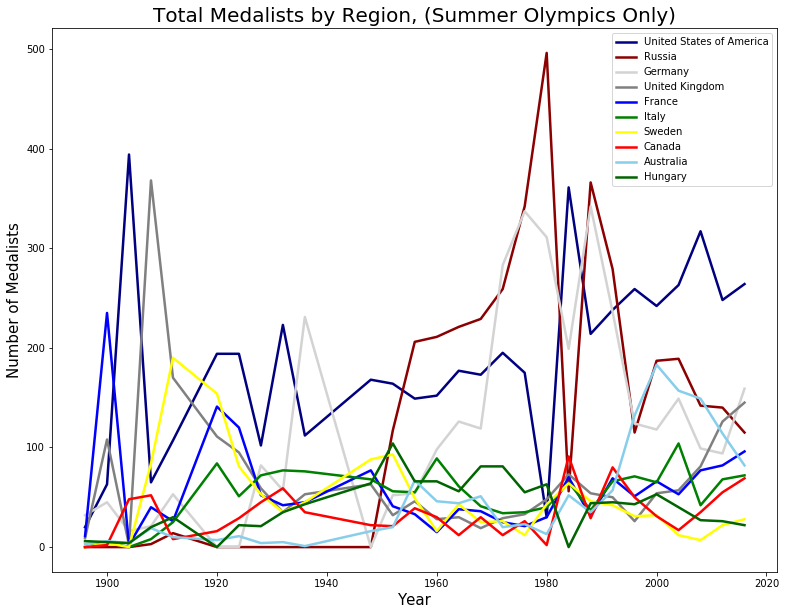

In [96]:
colors = ['navy','darkred','lightgrey','grey','blue','green','yellow','red','skyblue','darkgreen']
plt.figure(0,(13,10))

medals_overtime_summer = medals_overtime.loc[:,summer_years]
for i in range(len(medals_overtime_summer)):
    plt.plot(medals_overtime_summer.columns, medals_overtime_summer.iloc[i], '-', color=colors[i], lw=2.5, label = medals_overtime_summer.index[i])
plt.title('Total Medalists by Region, (Summer Olympics Only)', size=20)
plt.xlabel('Year', size=15)
plt.ylabel('Number of Medalists', size=15)
plt.legend(loc = 'best')

plt.savefig("2_plots/4 - Summer Medals Over Time for the Top 10 Countries.png")

plt.show()

Plotting on a single graph, we observed that Russia had an exponential jump in 1952 and another big jump in 1980.
Interestingly, after digging deeper into those data points we found out that Russia (Soviet Union at the time) joined the Olympics for the first time in the Summer of  1952  in Helsinki after World War II, and proclaimed that they “[amassed a larger total point score than any other nation and won more medals than anyone else](https://timesmachine.nytimes.com/timesmachine/1952/08/05/84341474.html?pageNumber=23)” on media, however without a lists of overall scores to prove the point.
Additionally, the 1980 is when Olympics was held in Moscow, Russia, where the nation’s suspicious act of manipulating the match scores peaked. In 1980 in Moscow, extremely disturbed by this action, the US players boycotted the games ; Then in 1984 Olympics in LA, Russian players boycotted the games. US and Russia created a lot of tension during this period.

# 3. What are some factors that may impact a country's Olympic success?

## <font color=green>**Wealth**</font>  $\;\;\;\;\;$ |  $\;\;\;\;\;$ <font color=red>**Health**</font> $\;\;\;\;\;$ | $\;\;\;\;\;$ <font color=gold>**Happiness**</font> $\;\;\;\;\;$ | $\;\;\;\;\;$ <font color=darkorchid>**Liberty**</font> $\;\;\;\;\;$ | $\;\;\;\;\;$ <font color=deepskyblue>**Environment**</font>

---
## 3.1 <font color=green>Wealth</font>: <font size=4>Correlation between GDP and Performance</font> <br> <font size=2 color=lightgrey>by Warren</font>

#### Data Cleaning and Manipulation

In [97]:
# Read CSV into Pandas DataFrame for both GDP and GDP per Capita data
raw_GDP_df = pd.read_csv('0_raw_data/CLEAN-GDPcurrent-USD-countries.csv')
raw_GDPpC_df = pd.read_csv('0_raw_data/CLEAN-GDPPC-USD-countries.csv')

#> raw_GDP_df.head(17)
#> raw_GDPpC_df.head(3)

In [98]:
# We do not need the Country ID, and we recall that our term for 
#  countries in the previous dataframes is 'Region'
raw_GDP_df = raw_GDP_df.drop(columns=['CountryID'])
raw_GDP_df = raw_GDP_df.rename(columns={'Country': 'Region'})

raw_GDPpC_df = raw_GDPpC_df.drop(columns=['CountryID'])
raw_GDPpC_df = raw_GDPpC_df.rename(columns={'Country': 'Region'})

#> raw_GDP_df.head(17)
#> raw_GDPpC_df.head(3)

In [99]:
# We only care about GDP and since it is always the largest figure for
#  each country, we can simply group by Region and use .max() 
#   to keep the GDP figures

GDP_groupedby_Region = raw_GDP_df.groupby('Region')
GDP_df = pd.DataFrame(GDP_groupedby_Region.max())
GDP_df = GDP_df.reset_index()
GDPpC_df = raw_GDPpC_df # no need to group the GDPpC data because there is only one row per country
GDP_df

# Given that there are only 195 countries but we have 221 Rows,
#  we know that some of these countries no longer exist. Luckily, 
#   they will be sorted out when we merge into the Olympic countries list

,Region,IndicatorName,1970,1971,1972,1973,1974,1975,1976,1977,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,"Wholesale, retail trade, restaurants and hotel...",1.748905e+09,1.831129e+09,1.595573e+09,1.733352e+09,2.155579e+09,2.366692e+09,2.555584e+09,2.953365e+09,...,1.381317e+10,1.790740e+10,1.987430e+10,2.133087e+10,2.161037e+10,2.133066e+10,2.060809e+10,2.023507e+10,2.151550e+10,2.051388e+10
1,Albania,"Wholesale, retail trade, restaurants and hotel...",2.345798e+09,2.413182e+09,2.482484e+09,2.553736e+09,2.627172e+09,2.702560e+09,2.780001e+09,2.860395e+09,...,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138692e+10,1.186136e+10,1.302507e+10,1.505888e+10
2,Algeria,"Wholesale, retail trade, restaurants and hotel...",5.323634e+09,5.653395e+09,7.431972e+09,9.441398e+09,1.350694e+10,1.565680e+10,1.775003e+10,2.099094e+10,...,1.370000e+11,1.610000e+11,2.000000e+11,2.090000e+11,2.100000e+11,2.140000e+11,1.660000e+11,1.600000e+11,1.670000e+11,1.740000e+11
3,Andorra,"Wholesale, retail trade, restaurants and hotel...",9.947679e+07,1.131285e+08,1.435060e+08,1.908638e+08,2.360555e+08,2.785143e+08,2.875884e+08,3.213901e+08,...,3.660304e+09,3.355494e+09,3.442273e+09,3.164644e+09,3.281764e+09,3.350604e+09,2.811614e+09,2.877201e+09,3.020852e+09,3.238225e+09
4,Angola,"Wholesale, retail trade, restaurants and hotel...",3.806982e+09,4.007445e+09,4.102155e+09,5.016276e+09,5.626961e+09,4.147433e+09,3.980907e+09,4.344225e+09,...,7.030719e+10,8.416464e+10,1.130000e+11,1.310000e+11,1.400000e+11,1.470000e+11,1.160000e+11,1.010000e+11,1.220000e+11,1.060000e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,Yemen Democratic (Former),"Wholesale, retail trade, restaurants and hotel...",1.926451e+08,1.780333e+08,1.987563e+08,1.624596e+08,1.744309e+08,1.748030e+08,2.273824e+08,2.929190e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,Yugoslavia (Former),"Wholesale, retail trade, restaurants and hotel...",1.455360e+10,1.580174e+10,1.648471e+10,2.147193e+10,2.970621e+10,3.327920e+10,3.756275e+10,4.567289e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,Zambia,"Wholesale, retail trade, restaurants and hotel...",1.544192e+09,1.574165e+09,1.851647e+09,2.349834e+09,2.894548e+09,2.839211e+09,2.813703e+09,2.767426e+09,...,1.532830e+10,2.026540e+10,2.448759e+10,2.484821e+10,2.658525e+10,2.669314e+10,2.085896e+10,2.145266e+10,2.586814e+10,2.728285e+10
219,Zanzibar,"Wholesale, retail trade, restaurants and hotel...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.560397e+08,8.167336e+08,8.606234e+08,1.006947e+09,1.147181e+09,1.298364e+09,1.183846e+09,1.262100e+09,1.448096e+09,1.618001e+09


In [103]:
# Because we don't have GDP data dating back to the early 1900's like
#  we do Olympics data, we will just focus on the most recent Games

# Create a new df for each 
recent_GDP_df = GDP_df[['Region']]
recent_GDPpC_df = GDPpC_df[['Region']]

# Make a single column which has the average GDP figures surrounding the 
#  most recent Summer and Winter Olympic Games
recent_GDP_df['GDP'] = round(GDP_df[['2008','2009','2010','2011',
                                     '2012','2013','2014',
                                     '2015','2016','2017',
                                     '2018']].mean(axis=1)/(10**9),3)

recent_GDPpC_df['GDPpC'] = round(GDPpC_df[['2008','2009','2010','2011',
                                           '2012','2013','2014',
                                           '2015','2016','2017',
                                           '2018']].mean(axis=1),1)

recent_GDP_df # We can see that 'Former' countries have no new data

,Region,GDP
0,Afghanistan,19.274
1,Albania,12.673
2,Algeria,179.000
3,Andorra,3.292
4,Angola,110.819
...,...,...
216,Yemen Democratic (Former),NaN
217,Yugoslavia (Former),NaN
218,Zambia,22.871
219,Zanzibar,1.103


In [113]:
# We will now merge the data with our previous medal count data
gender_medalled_GDP_df = pd.merge(
    gender_medalled_df, recent_GDP_df, 
    on='Region', how='left')

gender_medalled_GDP_df = pd.merge(
    gender_medalled_GDP_df, recent_GDPpC_df, 
    on='Region', how='left')

gender_medalled_GDP_df.head(3)

,Region,Medal_Females,Medal_Males,Medal_Total,Percent_Female,Percent_Male,GDP,GDPpC
0,Argentina,17.0,24.0,41.0,41.46,58.54,525.727,12413.7
1,Armenia,1.0,6.0,7.0,14.29,85.71,10.978,3772.2
2,Australia,108.0,94.0,202.0,53.47,46.53,1358.182,58508.3


In [114]:
# Check to see if we have any Regions withough GDP data
gender_medalled_GDP_df.loc[gender_medalled_GDP_df.GDP.isnull() == True]

,Region,Medal_Females,Medal_Males,Medal_Total,Percent_Female,Percent_Male,GDP,GDPpC
43,Moldova,1.0,1.0,2.0,50.0,50.0,NaN,NaN
65,Taiwan,7.0,0.0,7.0,100.0,0.0,NaN,NaN
84,Individual Olympic Athletes,0.0,2.0,2.0,0.0,100.0,NaN,NaN


In [115]:
# We only need to fix Taiwan's and Moldova's GDP values,
gender_medalled_GDP_df.set_value(65, 'GDP', 586.104)
gender_medalled_GDP_df.set_value(65, 'GDPpC', 24828.0)

gender_medalled_GDP_df.set_value(43, 'GDP', 12.037)
gender_medalled_GDP_df.set_value(43, 'GDPpC', 3398.0)
 

# because obviously the Individual Olympic Athletes have no GDP
gender_medalled_GDP_df = gender_medalled_GDP_df.dropna()

<font size=2> Source: [Economy_of_Taiwan](https://en.wikipedia.org/wiki/Economy_of_Taiwan) and [Economy_of_Moldova](https://en.wikipedia.org/wiki/Economy_of_Moldova)</font>

### Plotting Olympic Success versus Country Wealth

The correlation value (r) is: 0.8343852740235819


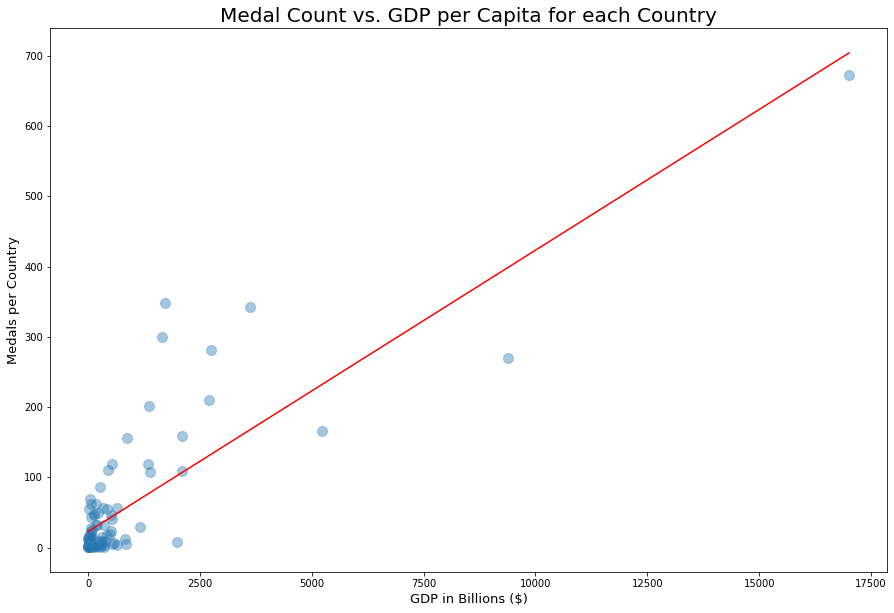

In [117]:
# Plot Country GDP versus Total Medal Count
x_values = gender_medalled_GDP_df.GDP
y_values = gender_medalled_GDP_df.Medal_Total

# And create the regression line showing correlation
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(15,10))
plt.scatter(x_values, y_values, s=100, edgecolor='steelblue', alpha=.4)
plt.plot(x_values.sort_values(), regress_values.sort_values(), 'r-')
plt.title('Medal Count vs. GDP per Capita for each Country', size=20)
plt.xlabel('GDP in Billions ($)', size=13)
plt.ylabel('Medals per Country', size=13)
print(f"The correlation value (r) is: {rvalue}")
plt.show()

The correlation value (r) is: 0.8343852740235819


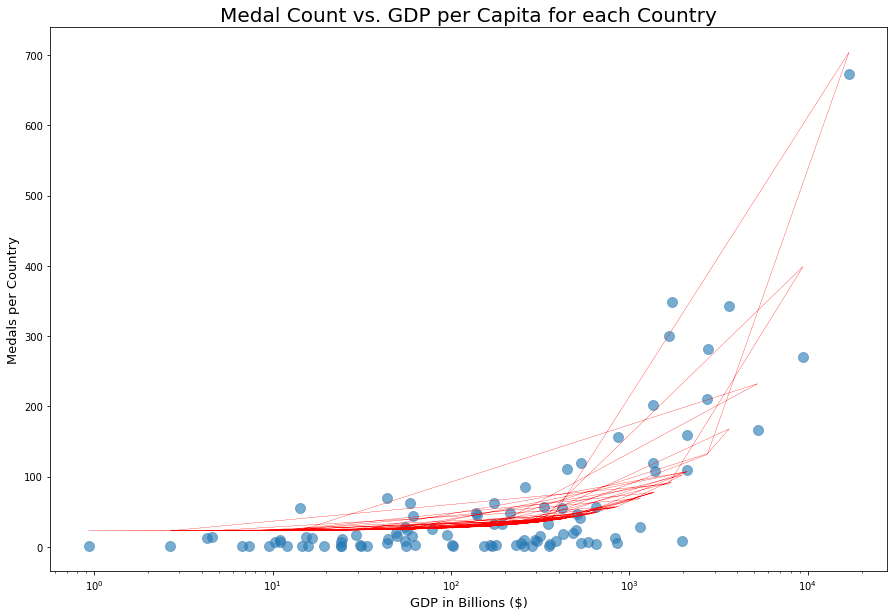

In [118]:
# The abover plot is a little difficult to see due to the clustering of values near the origin
# This is because the USA's GDP dwarfs most other countries'
# We can correct for thi by using log on the x-axis
x_values = gender_medalled_GDP_df.GDP
y_values = gender_medalled_GDP_df.Medal_Total

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(15,10))
plt.scatter(x_values, y_values, s=100, edgecolor='steelblue', alpha=.6)
plt.plot(x_values, regress_values, 'r-', lw=0.3)
plt.title('Medal Count vs. GDP per Capita for each Country', size=20)
plt.xlabel('GDP in Billions ($)', size=13)
plt.ylabel('Medals per Country', size=13)
plt.xscale('log')
print(f"The correlation value (r) is: {rvalue}")
plt.show()

The correlation value (r) is: 0.8343852740235819


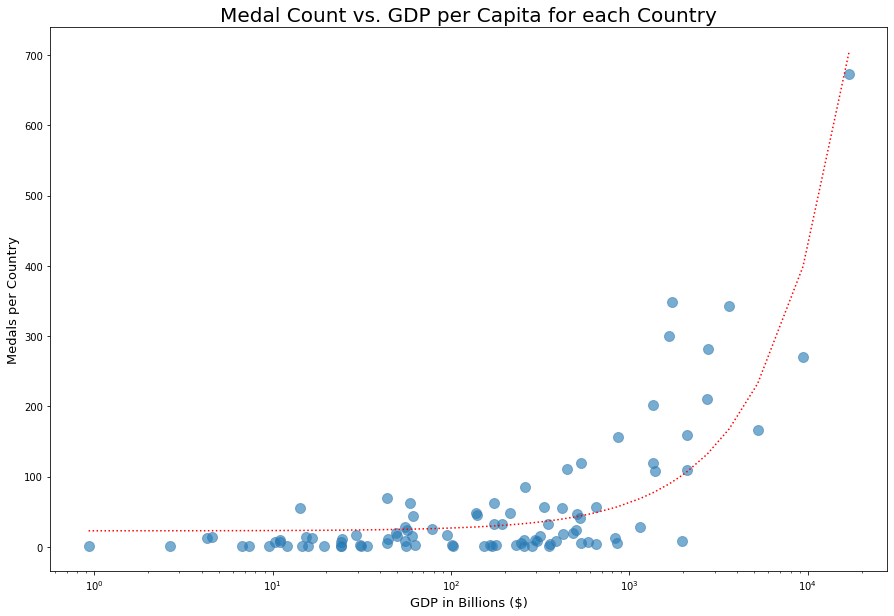

In [119]:
# I left the above in the presentation because it is a good example of how MatPlotLib.plot() actually works
# Because the regress_values are in no particular order (actually, they're in alphabetical order by country technically),
# the way plot works is that it simply connects the Nth value of (x,y) to the Nth+1 value
# We can combat this by sorting the (x,y) values as seen below
x_values = gender_medalled_GDP_df.GDP
y_values = gender_medalled_GDP_df.Medal_Total

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(15,10))
plt.scatter(x_values, y_values, s=100, edgecolor='steelblue', alpha=.6)
# Sort the (x,y) values to ensure a smooth regression curve on the log plot
plt.plot(x_values.sort_values(), regress_values.sort_values(), 'r:')
plt.title('Medal Count vs. GDP per Capita for each Country', size=20)
plt.xlabel('GDP in Billions ($)', size=13)
plt.ylabel('Medals per Country', size=13)
plt.xscale('log')
print(f"The correlation value (r) is: {rvalue}")
plt.show()

The correlation value (r) is 0.403 with a p-value of 4.603360576386678e-05


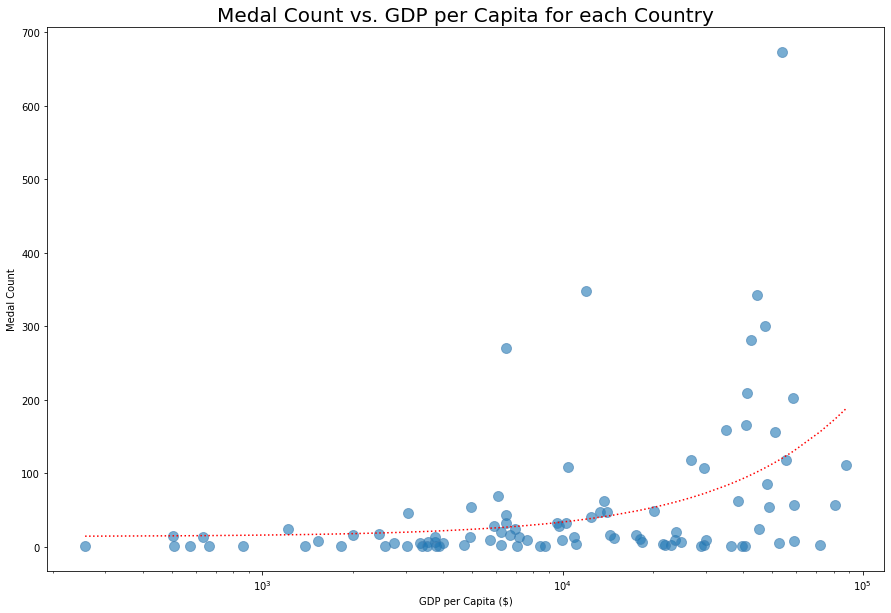

In [120]:
# Now let's check out Medal Count versus GDP per Capita
x_values = gender_medalled_GDP_df.GDPpC
y_values = gender_medalled_GDP_df.Medal_Total

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(15,10))
plt.scatter(x_values, y_values, s=100, edgecolor='steelblue', alpha=.6)
plt.plot(x_values.sort_values(), regress_values.sort_values(), 'r:')
plt.title('Medal Count vs. GDP per Capita for each Country', size=20)
plt.xlabel('GDP per Capita ($)')
plt.ylabel('Medal Count')
plt.xscale('log')
print(f"The correlation value (r) is {round(rvalue,3)} with a p-value of {pvalue}")
plt.show()

The correlation value (r) is 0.834 with a p-value of 4.705530389859702e-26


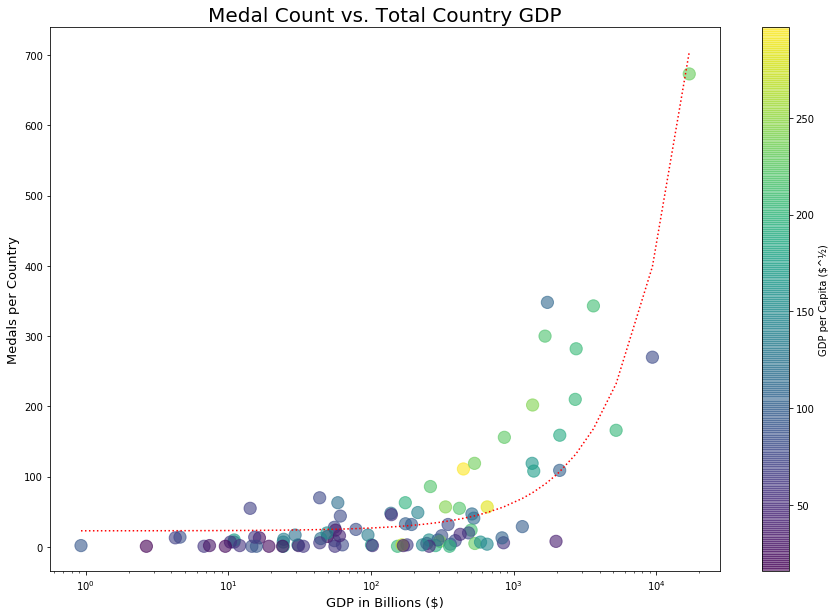

In [121]:
# Not as much of a correlation as before so we will stick to comparing the total GDP
# but we can add a colored z-axis for fun that shows GDP per Capita

x_values = gender_medalled_GDP_df.GDP
y_values = gender_medalled_GDP_df.Medal_Total
z_values = gender_medalled_GDP_df.GDPpC

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(15,10))
plt.scatter(x_values, y_values, c=z_values**(1/2), s=150, alpha=.6)
plt.plot(x_values.sort_values(), regress_values.sort_values(), 'r:')
plt.title('Medal Count vs. Total Country GDP', size=20)
plt.xlabel('GDP in Billions ($)', size=13)
plt.ylabel('Medals per Country', size=13)
plt.xscale('log')
plt.colorbar(label='GDP per Capita ($^½)')
print(f"The correlation value (r) is {round(rvalue,3)} with a p-value of {pvalue}")

plt.savefig("2_plots/5 - Medal Count vs GDP (per Capita as colorbar).png")

plt.show()

#### This scatter plot shows the a country's medal count versus their GDP, and has the GDP per Capita in the colored z-axis. We can see that there is a huge correlation between GDP and a country's Olympic performance. 
---

---
## 3.2 <font color=red>Health</font>: <font size=4>Correlation between Obesity Rates and Performance</font> <br> <font size=2 color=lightgrey>by Amber</font>

In [123]:
#data file
filepath = "0_raw_data/World Obesity Rate.csv"

WOR_df = pd.read_csv(filepath, engine='python')

WOR_df.head(6)

,regions,gender,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,F,3.22,3.39,3.58,3.78,3.99,4.20,4.43,4.66,4.91,5.16,5.43,5.71,6.00,6.31,6.62,6.95,7.29,7.65
1,Afghanistan,M,1.10,1.17,1.25,1.34,1.43,1.52,1.62,1.73,1.84,1.96,2.09,2.22,2.36,2.52,2.68,2.85,3.03,3.22
2,Angola,F,5.34,5.63,5.94,6.25,6.58,6.93,7.29,7.66,8.04,8.44,8.85,9.27,9.70,10.15,10.61,11.09,11.57,12.07
3,Angola,M,1.32,1.41,1.51,1.62,1.73,1.85,1.98,2.12,2.26,2.42,2.58,2.76,2.94,3.14,3.34,3.56,3.80,4.05
4,Albania,F,14.34,14.67,15.02,15.40,15.79,16.20,16.62,17.06,17.51,17.98,18.45,18.92,19.40,19.88,20.36,20.84,21.33,21.80
5,Albania,M,11.21,11.65,12.13,12.63,13.15,13.70,14.27,14.86,15.47,16.11,16.75,17.42,18.09,18.77,19.46,20.16,20.86,21.57


In [124]:
# Choosing the recent years
col = WOR_df.loc[: , "2012":"2016"]
WOR_df['Recent Avg. Obesity Rate'] = col.mean(axis=1)
recent_WOR_df = WOR_df[['regions','gender','Recent Avg. Obesity Rate']]
recent_WOR_df =recent_WOR_df.rename(columns={"regions": "Region", "gender":'Sex'})
recent_WOR_df.head(6)

,Region,Sex,Recent Avg. Obesity Rate
0,Afghanistan,F,6.964
1,Afghanistan,M,2.860
2,Angola,F,11.098
3,Angola,M,3.578
4,Albania,F,20.842
5,Albania,M,20.164


In [125]:
#limit data to show only the two most recent Olympics (one Summer and one Winter)
cleaned_olympicsMedals = olympicsMedals[['Region','Year','Sex','MedalCount']].reset_index(drop=True)
cleaned_olympicsMedals = cleaned_olympicsMedals.loc[cleaned_olympicsMedals["Year"] >= 2014]
grouped_olympicMedals = cleaned_olympicsMedals.groupby(['Region','Sex']).sum().reset_index()
del grouped_olympicMedals['Year']
grouped_olympicMedals= grouped_olympicMedals.sort_values('MedalCount')
grouped_olympicMedals

,Region,Sex,MedalCount
0,Afghanistan,F,0
245,Namibia,F,0
244,Myanmar,M,0
243,Myanmar,F,0
242,Mozambique,M,0
...,...,...,...
65,Canada,F,101
294,Russia,F,105
131,Germany,M,113
381,United States of America,M,140


In [126]:
WOR_merged = pd.merge(
    recent_WOR_df, grouped_olympicMedals, 
    how='outer', on=['Region','Sex']).reset_index(drop=True).dropna()
WOR_F = WOR_merged[WOR_merged['Sex'] == "F"]
WOR_M = WOR_merged[WOR_merged['Sex'] == "M"]
WOR_merged

,Region,Sex,Recent Avg. Obesity Rate,MedalCount
0,Afghanistan,F,6.964,0.0
1,Afghanistan,M,2.860,0.0
2,Angola,F,11.098,0.0
3,Angola,M,3.578,0.0
4,Albania,F,20.842,0.0
...,...,...,...,...
373,South Africa,M,14.178,21.0
374,Zambia,F,11.520,0.0
375,Zambia,M,3.210,0.0
376,Zimbabwe,F,24.358,0.0


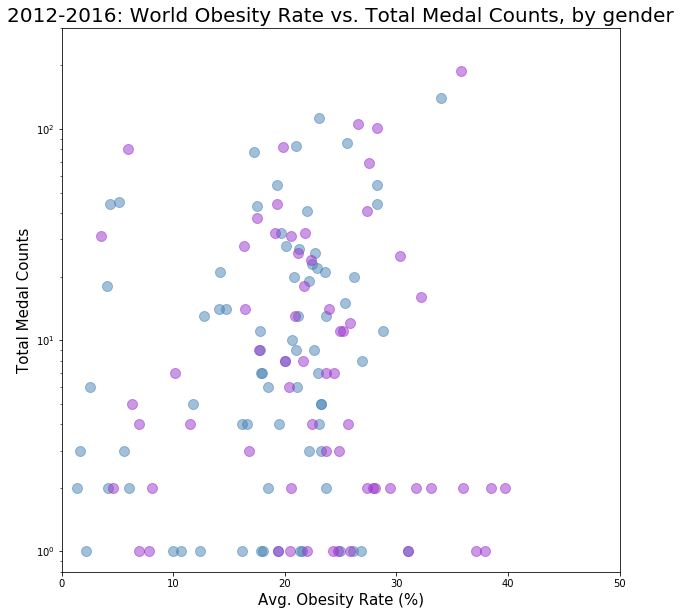

In [138]:

M_x_values = pd.to_numeric(WOR_M['Recent Avg. Obesity Rate']).astype(float)
M_y_values = pd.to_numeric(WOR_M['MedalCount']).astype(float)
F_x_values = pd.to_numeric(WOR_F['Recent Avg. Obesity Rate']).astype(float)
F_y_values = pd.to_numeric(WOR_F['MedalCount']).astype(float)


plt.figure(0,(10,10))
plt.scatter(M_x_values,M_y_values,facecolors="steelblue", alpha=0.5, s=100)
plt.scatter(F_x_values,F_y_values,facecolors="darkorchid", alpha=0.5, s=100)
plt.yscale('log')
plt.xlim(0,50)
plt.ylim(0.8,300)
plt.xlabel('Avg. Obesity Rate (%)', size=15)
plt.ylabel('Total Medal Counts', size=15)
plt.title('2012-2016: World Obesity Rate vs. Total Medal Counts, by gender', size=20)

plt.savefig("2_plots/6 - Recent World Obesity Rate vs Total Medal Counts, by gender.png")

plt.show()

In [139]:
coefficient_female=stats.pearsonr(WOR_F['Recent Avg. Obesity Rate'],WOR_F['MedalCount'])[0]
pvalue_female=stats.pearsonr(WOR_F['Recent Avg. Obesity Rate'],WOR_F['MedalCount'])[1]
print(f"The correlation for female is {round(coefficient_female,4)} and the p-value is {round(pvalue_female,4)}")

coefficient_male=stats.pearsonr(WOR_M['Recent Avg. Obesity Rate'],WOR_M['MedalCount'])[0]
pvalue_male=stats.pearsonr(WOR_M['Recent Avg. Obesity Rate'],WOR_M['MedalCount'])[1]
print(f"The correlation for male is {round(coefficient_male,4)} and the p-value is {round(pvalue_male,4)}")

The correlation for female is 0.0584 and the p-value is 0.4545
The correlation for male is 0.2339 and the p-value is 0.0022


We looked into how health affects performance in Olympics. we decided to look at the average obesity rate of regions vs. total number of medals, because obesity can lead to many fatal diseases according to an [NCBI study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5644725/). “Although overweight and obesity are considered the 5th leading risk for global deaths according to the WHO, clear opportunities for diagnosis and, consequently, treatment are being missed. Since obesity truly is a ‘gateway’ to so many other disease areas, it will block, if appropriately managed and prevented, a major supply route to ill health.”
Our analysis, surprisingly showed that the higher the average obesity rate is in a region, the higher the total number of medals, and this positive correlation was stronger in men than in women. Our hypothesis is that higher GDP leads to higher average obesity rate, and this leads to higher number of male medalists.

---
## 3.3 <font color=gold>Happiness</font>: <font size=4>Correlation between Happiness and Performance</font> <br> <font size=2 color=lightgrey>by Amber</font>

In [140]:
#data file

filepath="0_raw_data/Happiness_Index (2015 -2019).csv"

happiness_df=pd.read_csv(filepath)

happiness_df.tail(20)

,Year,Overall rank,Country or region,Happiness Score,GDP per capita
762,2015,139,Congo (Brazzaville),3.989,0.67866
763,2015,140,Comoros,3.956,0.23906
764,2015,141,Uganda,3.931,0.21102
765,2015,142,Senegal,3.904,0.36498
766,2015,143,Gabon,3.896,1.06024
767,2015,144,Niger,3.845,0.06940
768,2015,145,Cambodia,3.819,0.46038
769,2015,146,Tanzania,3.781,0.28520
770,2015,147,Madagascar,3.681,0.20824
771,2015,148,Central African Republic,3.678,0.07850


In [141]:
#choose recent happiness score
happiness2016 = happiness_df.loc[happiness_df['Year']==2016].reset_index(drop = True)
del happiness2016['Year']
happiness2016 =happiness2016.rename(columns={"Country or region": "Region"})

In [142]:
#creating dataframe
medals2016 = pd.DataFrame(overtime_pivot[overtime_pivot.columns[[0,35]]])
medals2016['2016 % Share of Medals'] = medals2016[2016]/medals2016[2016].sum()
medals2016['2016 % Share of Medals'] = round(medals2016['2016 % Share of Medals'].mul(100).astype(float),2)
medals2016=medals2016.sort_values('2016 % Share of Medals', ascending = False)
medals2016=medals2016.rename(columns={"2016": "2016 Medals"})
medals2016

Year,Region,2016,2016 % Share of Medals
194,United States of America,264,13.06
67,Germany,159,7.86
193,United Kingdom,145,7.17
151,Russia,115,5.69
39,China,113,5.59
...,...,...,...
98,Laos,0,0.00
99,Latvia,0,0.00
100,Lebanon,0,0.00
101,Lesotho,0,0.00


In [143]:
#Exclude countries that haven't won any medals
happiness_merged_df = pd.merge(happiness2016, medals2016, how='outer', on='Region').reset_index(drop=True).dropna()
happiness_no_zeros_df = happiness_merged_df.loc[happiness_merged_df["2016 % Share of Medals"] > 0.0]
happiness_no_zeros_df.round(1)

,Overall rank,Region,Happiness Score,GDP per capita,2016,2016 % Share of Medals
0,1.0,Denmark,7.5,1.4,41.0,2.0
1,2.0,Switzerland,7.5,1.5,11.0,0.5
3,4.0,Norway,7.5,1.6,19.0,0.9
4,5.0,Finland,7.4,1.4,1.0,0.0
5,6.0,Canada,7.4,1.4,69.0,3.4
...,...,...,...,...,...,...
125,126.0,Georgia,4.3,0.8,7.0,0.4
128,129.0,Bulgaria,4.2,1.1,7.0,0.4
138,139.0,Ivory Coast,3.9,0.6,2.0,0.1
141,142.0,Niger,3.9,0.1,1.0,0.0


In [159]:
happiness_no_zeros_df.head(20)

,Overall rank,Region,Happiness Score,GDP per capita,2016,2016 % Share of Medals
0,1.0,Denmark,7.526,1.44178,41.0,2.03
1,2.0,Switzerland,7.509,1.52733,11.0,0.54
3,4.0,Norway,7.498,1.57744,19.0,0.94
4,5.0,Finland,7.413,1.40598,1.0,0.05
5,6.0,Canada,7.404,1.44015,69.0,3.41
6,7.0,Netherlands,7.339,1.46468,47.0,2.32
7,8.0,New Zealand,7.334,1.36066,36.0,1.78
8,9.0,Australia,7.313,1.44443,82.0,4.06
9,10.0,Sweden,7.291,1.45181,28.0,1.38
10,11.0,Israel,7.267,1.33766,2.0,0.10


The correlation value (r) is 0.3149022570834088 with a p-value of 0.004704605241297206


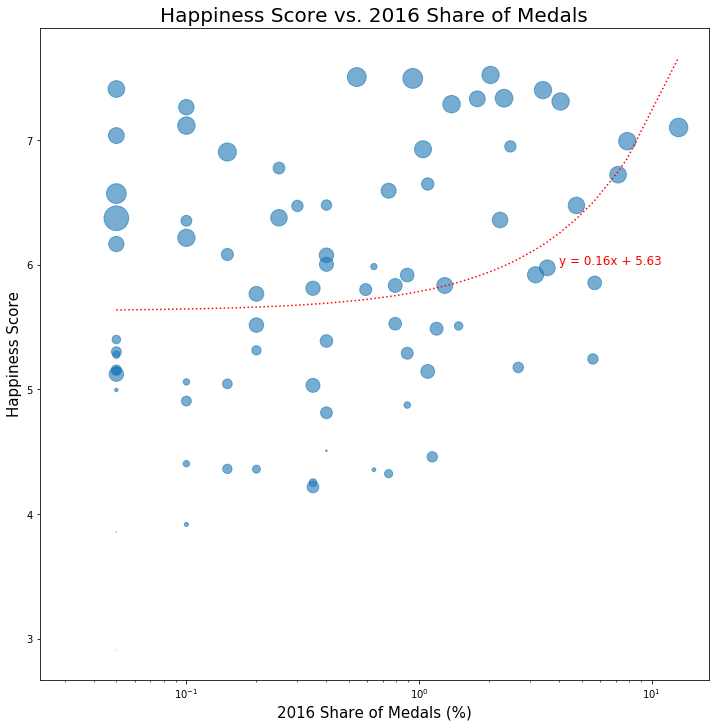

In [164]:
#plotting medals versus happiness
cleaned_happiness_merged = happiness_no_zeros_df[['Region','Happiness Score','GDP per capita','2016 % Share of Medals']].reset_index(drop=True)

x_values = pd.to_numeric(cleaned_happiness_merged['2016 % Share of Medals']).astype(float)
y_values = pd.to_numeric(cleaned_happiness_merged['Happiness Score']).astype(float)
z_values = pd.to_numeric(cleaned_happiness_merged['GDP per capita']).astype(float)

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(12,12))
plt.scatter(x_values, y_values, s=100*z_values**3, alpha=0.6)
plt.plot(x_values.sort_values(),regress_values.sort_values(),"r:")
plt.annotate(line_eq,(4,6),fontsize=12,color="r")
plt.xscale('log')
plt.xlabel('2016 Share of Medals (%)', size=15)
plt.ylabel('Happiness Score', size=15)
plt.title('Happiness Score vs. 2016 Share of Medals', size=20)
print(f"The correlation value (r) is {rvalue} with a p-value of {pvalue}")

plt.savefig("2_plots/7 - 2015 Happiness Score vs 2016 Share of Medals.png")

plt.show()

Looking into how mental health, more specifically how happiness leads to higher number of medals, we found that the happier a region is, the more likely it is to have a larger share of the medals in Olympics history.

---
## 3.4 <font color=mediumorchid>Liberty</font>: <font size=4>Correlation between Women's Freedom and Performance</font> <br> <font size=2 color=lightgrey>by Warren</font>

#### Data Cleaning and Manipulation

In [165]:
# Read CSV into Pandas DataFrame
raw_WPS_df = pd.read_csv('0_raw_data/WPS_Index_Raw_Data.csv')
WPS_df = raw_WPS_df[[
 'WPS Index rank',
 'Country and group',
 'WPS Index value']]
WPS_df = WPS_df.rename(columns={'Country and group': 'Region'})

#> WPS_df

In [166]:
# Merge the WPS data in with our previous medal count df from recent Olympics
medalled_WPS_df = pd.merge(medalled_recent_df, WPS_df, on='Region', how='left')
# Count the entries to see if any winning countries don't have WPS data
medalled_WPS_df.count()

Name               5081
Region             5081
Sex                5081
Age                5081
Medal              5081
Sport              5081
Event              5081
Year               5081
Season             5081
WPS Index rank     5018
WPS Index value    5018
dtype: int64

In [167]:
print("Unfortunately the following countries don't have WPS scores:")
list(medalled_WPS_df.loc[medalled_WPS_df['WPS Index rank'].isnull() == True].Region.unique())

Unfortunately the following countries don't have WPS scores:


['Cuba',
 'Bahamas',
 'North Korea',
 'Taiwan',
 'Puerto Rico',
 'Grenada',
 'Kosovo',
 'Individual Olympic Athletes']

In [169]:
print(f"Thankfully the above countries only account for {round(100*(medalled_WPS_df.Name.count()-medalled_WPS_df['WPS Index rank'].count())/medalled_WPS_df.Name.count(),1)}% of all recent medals.")

Thankfully the above countries only account for 1.2% of all recent medals.


In [170]:
# So we will drop off those countries
medalled_WPS_df = medalled_WPS_df.dropna()

medalled_WPS_df.count() # all counts should show 5018

Name               5018
Region             5018
Sex                5018
Age                5018
Medal              5018
Sport              5018
Event              5018
Year               5018
Season             5018
WPS Index rank     5018
WPS Index value    5018
dtype: int64

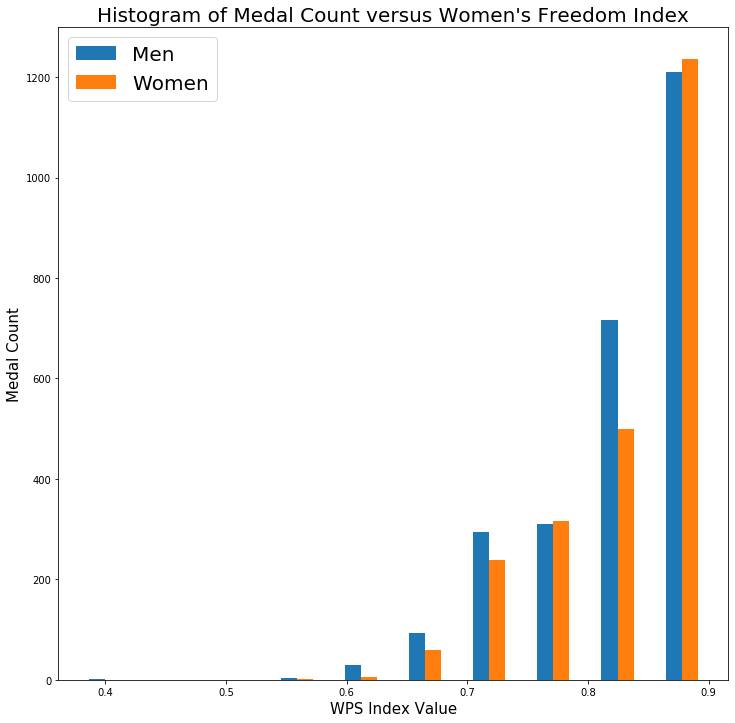

In [178]:
female_medalled_recent_WPS_df = medalled_WPS_df.loc[
    medalled_WPS_df.Sex == 'F']
male_medalled_recent_WPS_df = medalled_WPS_df.loc[
    medalled_WPS_df.Sex == 'M']

plt.figure(0,(12,12))
plt.hist([male_medalled_recent_WPS_df['WPS Index value'], 
          female_medalled_recent_WPS_df['WPS Index value']], 
         label=['Men', 'Women'], bins=10, rwidth=0.5)
plt.title("Histogram of Medal Count versus Women's Freedom Index", size=20)
plt.xlabel("WPS Index Value", size=15)
plt.ylabel("Medal Count", size=15)
plt.legend(fontsize=20, loc='upper left')
plt.show()

#### This histogram shows that countries in the 90th percentile of women's freedom see their female athletes bring home more metals than their male athletes. 
---

In [181]:
# Now let's add the WPS Index into the previously used df with GDP data
gender_medalled_GDP_WPS_df = pd.merge(
    gender_medalled_GDP_df, WPS_df, on='Region', how='left').dropna()

gender_medalled_GDP_WPS_df.count() # Should show 89 (96 medal-winning countries minus the 7 that don't have WPS scores)

Region             89
Medal_Females      89
Medal_Males        89
Medal_Total        89
Percent_Female     89
Percent_Male       89
GDP                89
GDPpC              89
WPS Index rank     89
WPS Index value    89
dtype: int64

In [182]:
# Output our new df as a CSV in case anyone want's to use it on its own
output_path = '1_clean_data/gender_medalled_GDP_WPS_df.csv'
gender_medalled_GDP_WPS_df.to_csv(output_path, index=False)

The correlation value (r) is 0.27 with a p-value of 0.010545371733510016


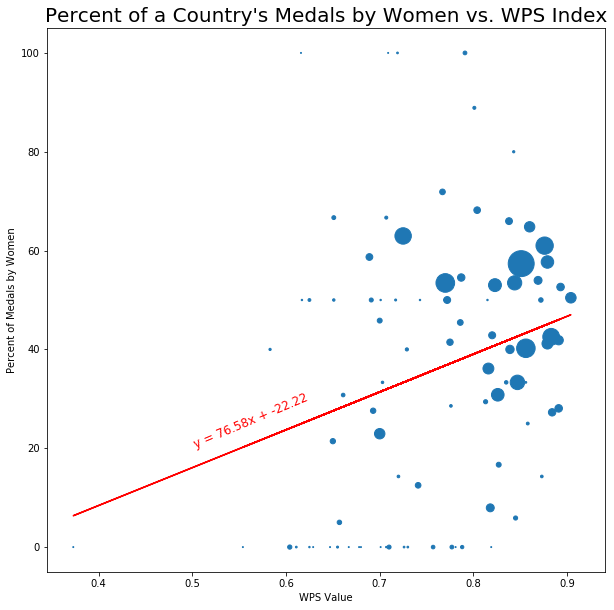

In [189]:
x_values = gender_medalled_GDP_WPS_df['WPS Index value']
y_values = gender_medalled_GDP_WPS_df['Percent_Female']
z_values = gender_medalled_GDP_WPS_df['Medal_Total']

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(10,10))
plt.scatter(x_values, y_values, s=z_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(.5,20),fontsize=12,color="red",rotation=23)
plt.title("Percent of a Country's Medals by Women vs. WPS Index", size=20)
plt.ylabel('Percent of Medals by Women')
plt.xlabel('WPS Value')
print(f"The correlation value (r) is {round(rvalue,3)} with a p-value of {pvalue}")

plt.show()

#### This scatter plot shows the percent of a country's medals won by their women versus the country's WPS index value. Unfortunately there was little conclusive evidence that an increase in women's rights in a particlar country results in women winning more of your country's medals. 
---

The correlation value (r) is 0.351 with a p-value of 0.0007400360419558767


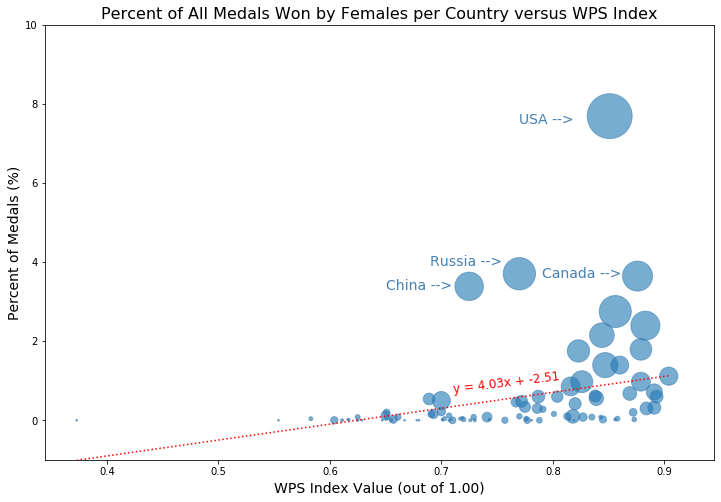

In [237]:
x_values = gender_medalled_GDP_WPS_df['WPS Index value']
y_values = 100*gender_medalled_GDP_WPS_df['Medal_Females']/gender_medalled_GDP_WPS_df.Medal_Total.sum()
z_values = gender_medalled_GDP_WPS_df['Medal_Total']

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(12,8))
plt.scatter(x_values, y_values, s=z_values*3, edgecolor='steelblue', alpha=.6)
plt.plot(x_values.sort_values(),regress_values.sort_values(),"r:")
plt.annotate(line_eq,(.71,.7),fontsize=12,color="red", rotation=7)
plt.annotate('USA -->',(.77,7.5),fontsize=14,color="steelblue")
plt.annotate('Russia -->',(.69,3.9),fontsize=14,color="steelblue")
plt.annotate('Canada -->',(.79,3.6),fontsize=14,color="steelblue")
plt.annotate('China -->',(.65,3.3),fontsize=14,color="steelblue")
plt.title('Percent of All Medals Won by Females per Country versus WPS Index', size=16)
plt.xlabel('WPS Index Value (out of 1.00)', size=14)
plt.ylabel('Percent of Medals (%)', size=14)
plt.ylim(-1,10)
print(f"The correlation value (r) is {round(rvalue,3)} with a p-value of {pvalue}")

plt.savefig("2_plots/8 - Country Medal-Share of Female Medals vs WPS Index.png")

plt.show()

#### This scatter plot shows a country's share of all medals won my femals versus the country's WPS index value. Here was see a little more evidence that an increase in women's rights results in an increase in Olympic success. Though this correlation is most likely more to do with the fact that countries with higher GDP's (and win more total medals) also have better women's rights. 
---

---
## 3.5 <font color=dodgerblue>Environment</font>: <font size=4>Correlation between Polution and Performance</font> <br> <font size=2 color=lightgrey>by Shashank</font>

In [251]:
#create the medal tally df for recent Olympic performance
recent_olympicsMedals_df = olympicsMedals.loc[olympics_df.Year >= 2014]

countrygroup=recent_olympicsMedals_df[["Region", "MedalCount", "Gold", "Silver", "Bronze"]].groupby(by="Region")

pollution_df=pd.DataFrame(countrygroup.sum().sort_values(by="MedalCount",ascending=False)).reset_index()

pollution_df.head(3)

,Region,MedalCount,Gold,Silver,Bronze
0,United States of America,328,149,84,95
1,Germany,195,64,55,76
2,Russia,183,85,50,48


In [252]:
# definition of 4 lists to get 4-corner bounds for each country
gm = googlemaps.Client(key=gkey)

lat1 = [None]*len(pollution_df.Region)
lat2 = [None]*len(pollution_df.Region)
lng1 = [None]*len(pollution_df.Region)
lng2 = [None]*len(pollution_df.Region)

for i in range(len(pollution_df.Region)):
    try:
        geocode_result = gm.geocode(pollution_df.Region[i])[0]
        lat1[i]=geocode_result["geometry"]["viewport"]["northeast"]["lat"]
        lat2[i]=geocode_result["geometry"]["viewport"]["southwest"]["lat"]
        lng1[i]=geocode_result["geometry"]["viewport"]["northeast"]["lng"]
        lng2[i]=geocode_result["geometry"]["viewport"]["southwest"]["lng"]
    except:
        continue
### this cell will take ~30 seconds to complete ###

In [253]:
# Replace NaNs with 0's
for i in range(len(lat1)):
    if pd.isnull(lat1[i]):
        lat1[i]=0
        lat2[i]=0
        lng1[i]=0
        lng2[i]=0

In [254]:
#adding 4-corner bounds to our pollution_df
pollution_df["lat1"]=lat1
pollution_df["lng1"]=lng1
pollution_df["lat2"]=lat2
pollution_df["lng2"]=lng2

pollution_df.lat1=pollution_df.lat1.astype(str)
pollution_df.lng1=pollution_df.lng1.astype(str)
pollution_df.lat2=pollution_df.lat2.astype(str)
pollution_df.lng2=pollution_df.lng2.astype(str)

pollution_df.head(3)

,Region,MedalCount,Gold,Silver,Bronze,lat1,lng1,lat2,lng2
0,United States of America,328,149,84,95,49.38,-66.94,25.82,-124.39
1,Germany,195,64,55,76,55.0815,15.0418962,47.2701115,5.8663425
2,Russia,183,85,50,48,70.0,179.0,40.0,27.0


In [255]:
# creating the bounds column with API required formatting
pollution_df["bounds"]=pollution_df.lat1.str.cat(pollution_df.lng1,sep=",").str.cat(pollution_df.lat2,sep=",").str.cat(pollution_df.lng2,sep=",")

pollution_df.head(3)

,Region,MedalCount,Gold,Silver,Bronze,lat1,lng1,lat2,lng2,bounds
0,United States of America,328,149,84,95,49.38,-66.94,25.82,-124.39,"49.38,-66.94,25.82,-124.39"
1,Germany,195,64,55,76,55.0815,15.0418962,47.2701115,5.8663425,"55.0815,15.0418962,47.2701115,5.8663425"
2,Russia,183,85,50,48,70.0,179.0,40.0,27.0,"70.0,179.0,40.0,27.0"


In [259]:
# request air quality data for all stations within the respective 4 bounds per country 
#  and calculate the average AQI level
url="https://api.waqi.info/map/bounds/"

avgPollution=[None]*len(pollution_df["bounds"])

for i in range(len(pollution_df["bounds"])):
    response=requests.get(url,params={"token":aqikey,"latlng":pollution_df["bounds"][i]}).json()
    numberOfStations=0
    totalaqi=0
    if len(response["data"])>0:
        for j in range(len(response["data"])):
            try:
                totalaqi+=int(response["data"][j]["aqi"])
                numberOfStations+=1
            except:
                continue
        if numberOfStations>0:
            avgPollution[i]=totalaqi/numberOfStations
    else:
        continue
### this cell will take ~150 seconds to complete ###

In [260]:
# adding average polution column to existing df and dropping off any countries with unfound polution
pollution_df["pollution"] = avgPollution
pollution_df = pollution_df.dropna()
pollution_df.head(3)

,Region,MedalCount,Gold,Silver,Bronze,lat1,lng1,lat2,lng2,bounds,pollution
0,United States of America,328,149,84,95,49.38,-66.94,25.82,-124.39,"49.38,-66.94,25.82,-124.39",25.543522
1,Germany,195,64,55,76,55.0815,15.0418962,47.2701115,5.8663425,"55.0815,15.0418962,47.2701115,5.8663425",34.028090
2,Russia,183,85,50,48,70.0,179.0,40.0,27.0,"70.0,179.0,40.0,27.0",77.845771


In [268]:
pollution_df.sort_values('pollution')

,Region,MedalCount,Gold,Silver,Bronze,lat1,lng1,lat2,lng2,bounds,pollution
164,Brunei,0,0,0,0,5.0978001,115.3639552,4.002460999999999,114.0752,"5.0978001,115.3639552,4.002460999999999,114.0752",14.400000
37,Fiji,13,13,0,0,-12.2084957,-177.8686523,-20.8998713,176.7919922,"-12.2084957,-177.8686523,-20.8998713,176.7919922",14.894737
76,Trinidad,1,0,0,1,11.4004,-60.45089989999999,9.9930001,-61.9725001,"11.4004,-60.45089989999999,9.9930001,-61.9725001",16.000000
145,Eritrea,0,0,0,0,18.0204137,43.2312,12.354723,36.433348,"18.0204137,43.2312,12.354723,36.433348",17.000000
108,Uruguay,0,0,0,0,-30.0852149,-53.0779284,-35.1558001,-58.4913609,"-30.0852149,-53.0779284,-35.1558001,-58.4913609",17.000000
...,...,...,...,...,...,...,...,...,...,...,...
155,Bangladesh,0,0,0,0,26.633914,92.6801153,20.3794,88.00861410000002,"26.633914,92.6801153,20.3794,88.00861410000002",125.500000
182,Myanmar,0,0,0,0,28.5478351,101.1702717,9.4518,92.171808,"28.5478351,101.1702717,9.4518,92.171808",133.672000
198,Laos,0,0,0,0,22.5090449,107.635094,13.9097198,100.0832139,"22.5090449,107.635094,13.9097198,100.0832139",145.400000
172,Mali,0,0,0,0,25.001084,4.267382599999999,10.147811,-12.2403447,"25.001084,4.267382599999999,10.147811,-12.2403447",151.000000


The correlation value (r) is -0.159 with a p-value of 0.0861819530507656


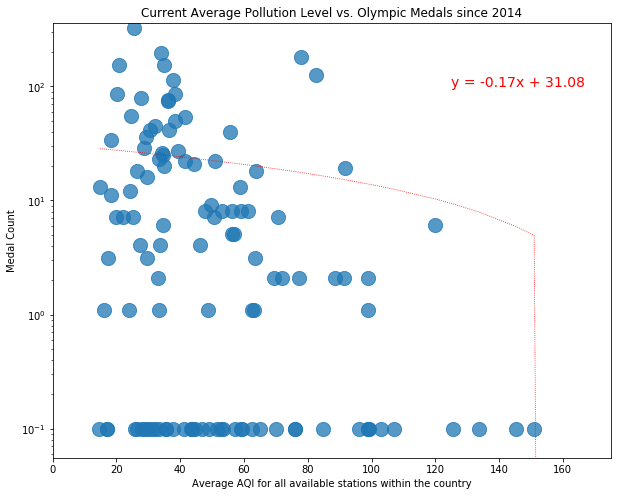

In [277]:
# plot the Olympic Medal Totals versus Polution

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(pollution_df.pollution, pollution_df.MedalCount)
regress_values = pollution_df.pollution * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(0,(10,8))
plt.scatter(pollution_df.pollution,pollution_df.MedalCount+0.1,s=200,alpha=0.75)
plt.plot(pollution_df.pollution.sort_values(ascending=False),regress_values.sort_values(),"r:",lw=.8)
plt.annotate(line_eq,(125,100),fontsize=14,color="red")
plt.yscale('log')
plt.title("Current Average Pollution Level vs. Olympic Medals since 2014")
plt.xlabel("Average AQI for all available stations within the country")
plt.ylabel("Medal Count")
plt.xlim(0,175)  #pollution_df.pollution.max())
plt.ylim(0,pollution_df.MedalCount.max()*1.1)

print(f"The correlation value (r) is {round(rvalue,3)} with a p-value of {pvalue}")

plt.savefig("2_plots/9 - Average Current Pollution Level vs Recent Olympic Performance.png")

plt.show()

# 4. How do the different sports and their competitors compare to each other?

---
## 4.1 Athlete Weights and Heights <br> <font size=2 color=lightgrey>by Mrudula</font>

In [278]:
#Obtain min, max, median values for Weight and Height
male_df = raw_olympics_df[raw_olympics_df.Sex=='M']
sport_weight_height_metrics = male_df.groupby(
    ['Sport'])['Weight','Height'].agg(['min','max','mean'])

sport_weight_height_metrics.dropna(how='all')

Weight                   Height                   
                             min    max       mean    min    max        mean
Sport                                                                       
Alpine Skiing               50.0  107.0  78.626035  142.0  200.0  177.891374
Archery                     46.0  130.0  77.066866  157.0  197.0  178.477842
Art Competitions            59.0   93.0  75.290909  150.0  190.0  174.896552
Athletics                   42.0  165.0  73.839129  148.0  208.0  179.768303
Badminton                   55.0   97.0  74.362536  160.0  201.0  179.620787
Baseball                    38.0  120.0  85.707792  147.0  206.0  182.599291
Basketball                  59.0  156.0  91.683529  163.0  226.0  194.872624
Beach Volleyball            62.0  110.0  89.512821  179.0  212.0  193.290909
Biathlon                    51.0   95.0  72.632123  160.0  200.0  178.856281
Bobsleigh                   55.0  145.0  90.387385  153.0  211.0  181.992015
Boxing                      46.0  140.0  65.296280  127.0  208.0  172.888199
Canoeing                    53.0  115.0  79.972378  158.0  205.0  181.212532
Cross Country Skiing        53.0  100.0  71.700832  155.0  200.0  177.757682
Curling                     61.0  105.0  81.465686  152.0  197.0  180.709251
Cycling                     48.0  104.0  72.190234  136.0  201.0  177.745402
Diving                      37.0   91.0  67.069378  148.0  188.0  171.555352
Equestrianism               50.0  100.0  70.924559  154.0  197.0  176.563172
Fencing                     48.0  108.0  75.381977  153.0  208.0  180.014125
Figure Skating              47.0   90.0  69.591644  156.0  193.0  176.062271
Football                    28.0  100.0  73.086644  140.0  200.0  177.480339
Freestyle Skiing            47.0  108.0  74.648148  149.0  197.0  176.442424
Golf                        63.0  104.0  79.245283  165.0  196.0  178.985915
Gymnastics                  46.0  102.0  63.343605  150.0  188.0  167.644438
Handball                    62.0  132.0  89.387914  140.0  214.0  188.778373
Hockey                      48.0  105.0  73.343761  150.0  200.0  176.852577
Ice Hockey                  52.0  116.0  83.775593  155.0  206.0  180.991444
Jeu De Paume                 NaN    NaN        NaN  176.0  181.0  178.500000
Judo                        52.0  214.0  83.573945  145.0  213.0  177.487500
Lacrosse                    60.0   98.0  76.714286  168.0  180.0  174.000000
Luge                        52.0  112.0  80.803311  157.0  199.0  179.242483
Modern Pentathlon           56.0   91.0  72.068824  152.0  198.0  179.087688
Motorboating                77.0   77.0  77.000000  181.0  181.0  181.000000
Nordic Combined             53.0   86.0  66.909560  160.0  193.0  176.504464
Polo                         NaN    NaN        NaN  169.0  178.0  175.500000
Racquets                     NaN    NaN        NaN  176.0  176.0  176.000000
Rowing                      37.0  137.0  83.665663  132.0  209.0  186.882698
Rugby                       68.0   99.0  77.533333  164.0  191.0  176.096774
Rugby Sevens                65.0  113.0  91.006623  169.0  198.0  182.834437
Sailing                     50.0  130.0  78.849712  151.0  213.0  180.156897
Shooting                    41.0  140.0  77.834960  132.0  213.0  175.977163
Short Track Speed Skating   51.0   86.0  71.401869  162.0  191.0  175.611482
Skeleton                    65.0  127.0  82.018349  157.0  198.0  181.072727
Ski Jumping                 50.0   85.0  65.245881  156.0  200.0  176.579710
Snowboarding                50.0  102.0  76.861598  157.0  194.0  178.526012
Speed Skating               50.0  100.0  76.300403  158.0  203.0  179.183060
Swimming                    45.0  114.0  78.040567  147.0  209.0  184.310928
Table Tennis                50.0   99.0  71.414239  150.0  198.0  177.008630
Taekwondo                   54.0  110.0  74.653595  160.0  207.0  182.418301
Tennis                      59.0  111.0  78.842912  162.0  208.0  184.847806
Trampolining          

#### Athlete Weights

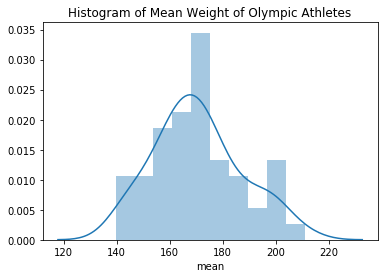

In [290]:
#Plot mean values of weight on a histogram
sns.distplot(sport_weight_height_metrics.Weight.dropna()['mean']*2.20462,bins=10) # multiply by 2.2 to get pounds
plt.title('Histogram of Mean Weight of Olympic Athletes')
plt.show()

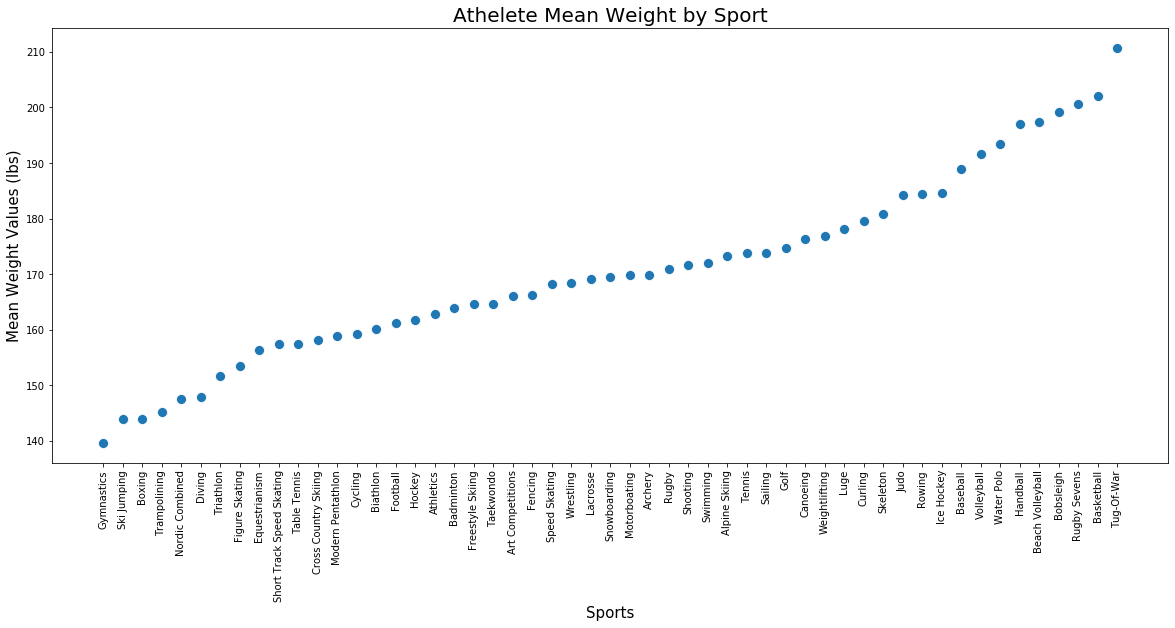

In [292]:
#Create a variable and store all the  weight values
means = list(sport_weight_height_metrics.Weight.dropna()['mean']*2.20462)

#create a variable and store all the index values
sports = list(sport_weight_height_metrics.Weight.dropna().index)

plot_data = sorted(zip(sports, means), key = lambda x:x[1])
plot_data_dict = {
    'x' : [i for i, _ in enumerate(plot_data)],
    'y' : [v[1] for i, v in enumerate(plot_data)],
    'group' :  [v[0] for i, v in enumerate(plot_data)]
}

plt.figure(0,(20,8))

#Plot a scatter plot for x,y values
sns.scatterplot(data = plot_data_dict, x = 'x' , y = 'y', s=100)
#set the x-ticks to be the respective sports
plt.xticks(np.arange(0,53),plot_data_dict['group'], rotation=90)
#set title for the fig
plt.title('Athelete Mean Weight by Sport', size=20)
# Set x-axis label
plt.xlabel('Sports', size=15)
# Set y-axis label
plt.ylabel('Mean Weight Values (lbs)', size=15)

plt.savefig("2_plots/10 - Variation of Weight in the Olympics.png")

plt.show()

#### Athlete Heights

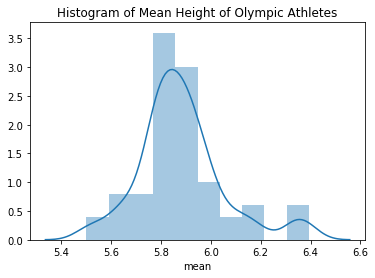

In [294]:
#Plot mean values of height on a histogram
sns.distplot(sport_weight_height_metrics.Height.dropna()['mean']*0.0328084, bins=10) # mutiply by 0.033 to get feet from cm
plt.title('Histogram of Mean Height of Olympic Athletes')
plt.show()

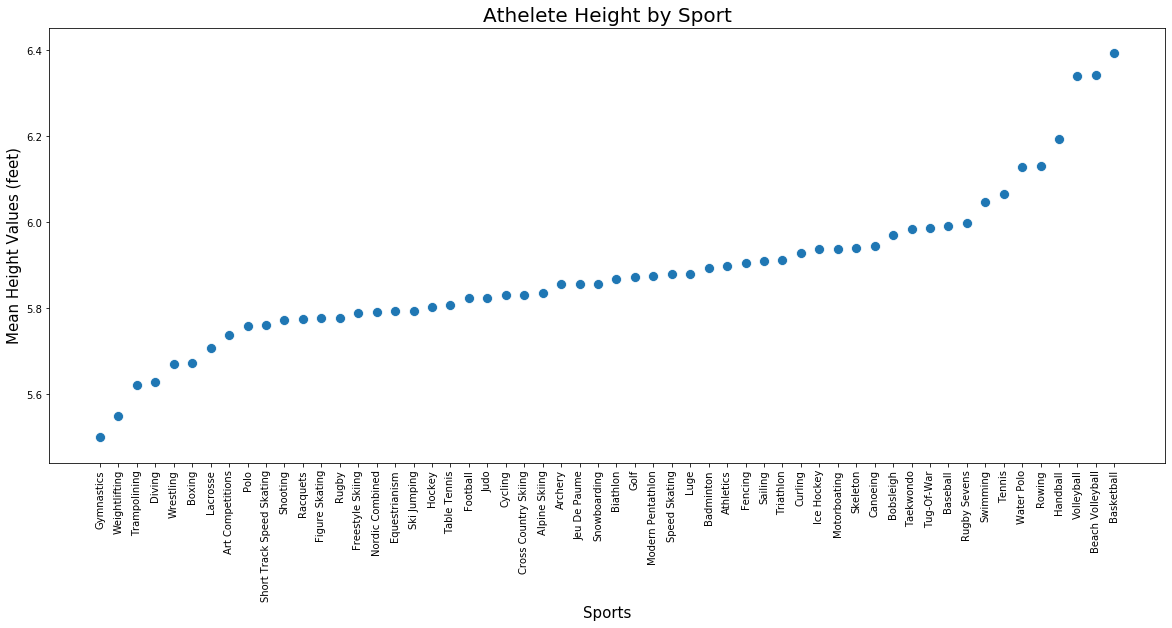

In [298]:
#Create a variable and store all the height values
means = list(sport_weight_height_metrics.Height.dropna()['mean']*0.0328084)

#create a variable and store all the index values
sports = list(sport_weight_height_metrics.Height.dropna().index)

plot_data = sorted(zip(sports, means), key = lambda x:x[1])
plot_data_dict = {
    'x' : [i for i, _ in enumerate(plot_data)],
    'y' : [v[1] for i, v in enumerate(plot_data)],
    'group' :  [v[0] for i, v in enumerate(plot_data)]
}

plt.figure(0,(20,8))

#Plot a scatter plot for x,y values
sns.scatterplot(data = plot_data_dict, x = 'x' , y = 'y', s=100)
#set the x-ticks to be the respective sports
plt.xticks(np.arange(0,56),plot_data_dict['group'], rotation=90)
#set title for the fig
plt.title('Athelete Height by Sport', size=20)
# Set x-axis label
plt.xlabel('Sports', size=15)
# Set y-axis label
plt.ylabel('Mean Height Values (feet)', size=15)

plt.savefig("2_plots/11 - Variation of Height in the Olympics.png")

plt.show()

#### Deeper dive into specific sport heights

In [299]:
# Let's take a look at Basketball in the Olympics
basketball_df = male_df[male_df.Sport=="Basketball"]

In [300]:
# Next we group by each year that basketball has been in the Olympics,
#  and we want to aggregate the mean and sem for height
sport_maxheight_metrics = basketball_df.groupby(['Year'])['Height'].agg(['mean','sem']).dropna().sort_values('Year', ascending=False)
sport_maxheight_metrics = sport_maxheight_metrics.reset_index()
sport_maxheight_metrics.head(3)

,Year,mean,sem
0,2016,200.503546,0.711366
1,2012,200.638889,0.698790
2,2008,200.076389,0.800828


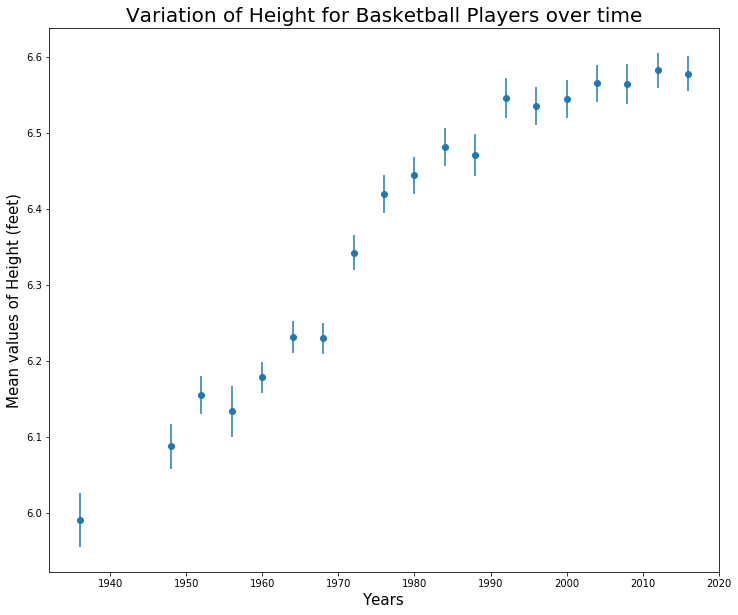

In [307]:
#Create variables to store Year, mean sem values
Year = sport_maxheight_metrics["Year"]
mean = sport_maxheight_metrics["mean"]
sem = sport_maxheight_metrics["sem"]


# Setting up the plot
plt.figure(0,(12,10))
plt.errorbar(Year, mean*0.0328084, sem*0.0328084, fmt="o")
plt.title("Variation of Height for Basketball Players over time", size=20)
plt.xlabel("Years", size=15)
plt.ylabel("Mean values of Height (feet)", size=15)
plt.savefig("2_plots/12 - Variation of Height for Basketball Players Over Time.png")
plt.show()

In [312]:
# Now let's take a look at Gymnastics in the Olympics
Gymnastics_df = male_df[male_df.Sport=="Gymnastics"]

In [313]:
# Again we group by each year that Gymnastics has been in the Olympics,
#  and we want to aggregate the mean and sem for height
sport_minheight_metrics = Gymnastics_df.groupby(['Year'])['Height'].agg(['mean','sem']).dropna().sort_values('Year', ascending=False)
sport_minheight_metrics = sport_minheight_metrics.reset_index()
sport_minheight_metrics.head(3)

,Year,mean,sem
0,2016,167.456067,0.245219
1,2012,166.703226,0.262410
2,2008,166.578378,0.214186


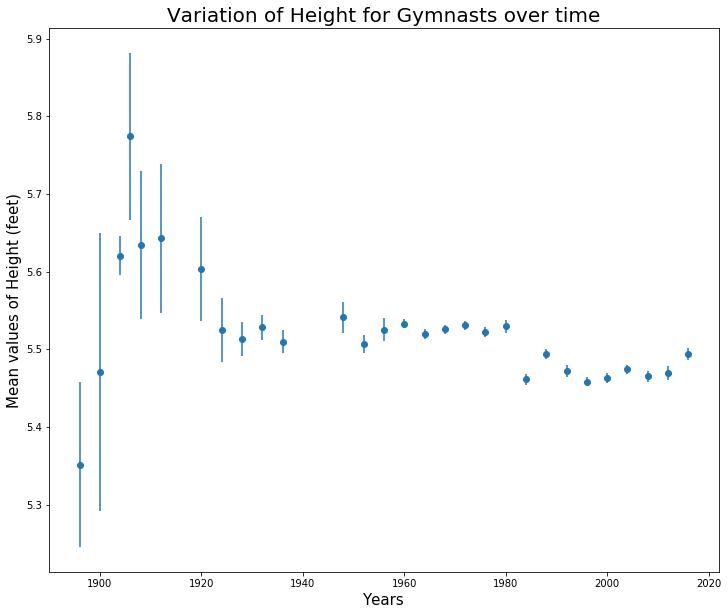

In [315]:
#Create variables to store Year, mean sem values
Year = sport_minheight_metrics["Year"]
mean = sport_minheight_metrics["mean"]
sem = sport_minheight_metrics["sem"]

# Setting up the plot
plt.figure(0,(12,10))
plt.errorbar(Year, mean*0.0328084, sem*0.0328084, fmt="o")
plt.title("Variation of Height for Gymnasts over time", size=20)
plt.xlabel("Years", size=15)
plt.ylabel("Mean values of Height (feet)", size=15)
plt.savefig("2_plots/12 - Variation of Height for Basketball Players Over Time.png")
plt.show()

---
## 4.2 Althete Performance at the Olympics <br> <font size=2 color=lightgrey>by Warren</font>


#### Number of events an athlete has participated in

In [316]:
# Let's take a dive into the individual athletes who have competed at the Olympics
olympics_groupedby_athlete = olympics_df.groupby('Name')
# Count the number of events an athlete has participated in
event_count = olympics_groupedby_athlete.count()['Sex'].sort_values(ascending=False)
# Who has participated the most?
event_count.head(10)

Name
Robert Tait McKenzie                58
Heikki Ilmari Savolainen            39
Joseph "Josy" Stoffel               38
Ioannis Theofilakis                 36
Takashi Ono                         33
Jean Lucien Nicolas Jacoby          32
Alfrd (Arnold-) Hajs (Guttmann-)    32
Alexandros Theofilakis              32
Andreas Wecker                      32
Alfred James Munnings               31
Name: Sex, dtype: int64

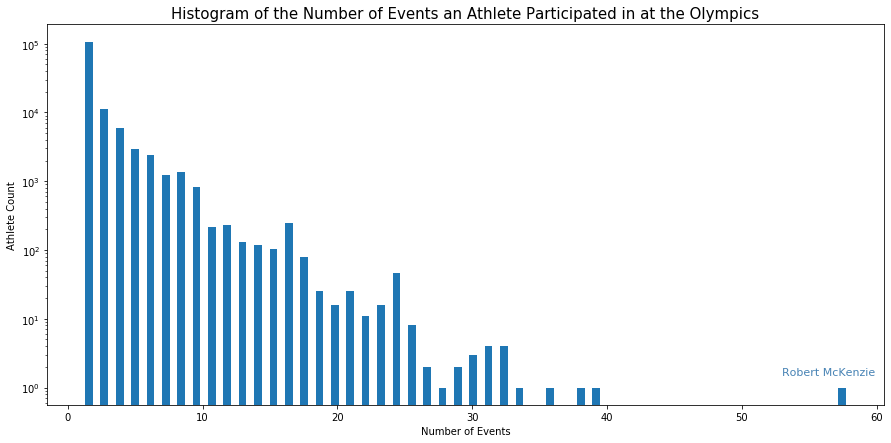

In [317]:
plt.figure(0,(15,7))
plt.hist(event_count, bins=50, log=True, rwidth=0.5)
plt.annotate('Robert McKenzie',(53,1.5),size=11,color='steelblue')
plt.xlabel("Number of Events")
plt.ylabel("Athlete Count")
plt.title('Histogram of the Number of Events an Athlete Participated in at the Olympics', size=15)
plt.show()

**Fun Fact:** the first half of the 20th Century saw art competitons in the Olympics. It should be fairly obvious that Robert McKenzie is an outlier in the number of Olympic competitions he has been apart of, and that's because he wasn't an athlete at all, he was a sculptor. Most all of the other top competitors were gymnists, being able to compete in many different competitions at every Games.

### Number of events an athlete *who has medalled* has participated in

In [318]:
# Start by making a df that we can operate on
olympics_groupedby_athlete_df = pd.DataFrame(olympics_groupedby_athlete.count())
# Then we filter out any athletes who haven't medalled
medalled_olymians_df = olympics_groupedby_athlete_df.loc[olympics_groupedby_athlete_df['Medal'] > 0]
# and follow the same steps as before
medalled_groupedby_athlete = medalled_olymians_df.groupby('Name')
medalled_event_count = medalled_groupedby_athlete.max()['Sex'].sort_values(ascending=False)
medalled_event_count.head(10)

Name
Robert Tait McKenzie                58
Heikki Ilmari Savolainen            39
Ioannis Theofilakis                 36
Takashi Ono                         33
Alfrd (Arnold-) Hajs (Guttmann-)    32
Jean Lucien Nicolas Jacoby          32
Alexandros Theofilakis              32
Andreas Wecker                      32
Alfred August "Al" Jochim           31
Michael Fred Phelps, II             30
Name: Sex, dtype: int64

As expected, many of the same names appear on this tailored list because surely if an athlete aprticipates in a bunch of competitions he/she will most likely have medalled. But there is one name missing...

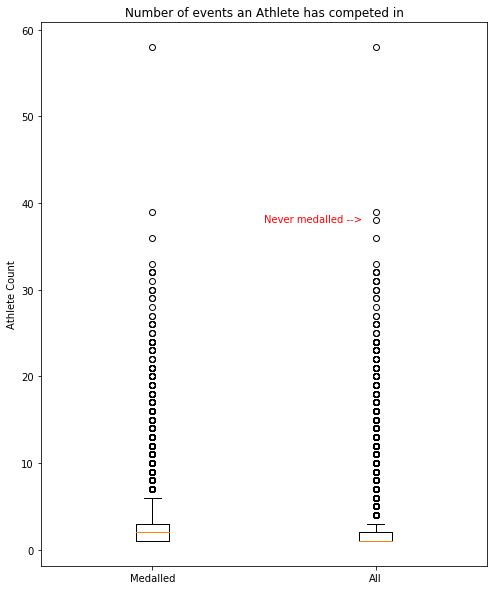

In [319]:
# Lets make a box-and-whisker plot to show all of the outliers 
plt.figure(0,(8,10))
plt.title('Number of events an Athlete has competed in')
plt.ylabel('Athlete Count')
plt.boxplot([medalled_event_count, event_count])
plt.xticks([1,2],['Medalled', 'All'])

# And here we see someone who competed in 38 events yet never once medalled
plt.annotate('Never medalled -->',(1.5,37.75),fontsize=10,color="red")
plt.show()

#### So who is Joseph "Josy" Stoffel?  
* Born on June 27th, 1928 (currently age 91) he went to 5 Summer Olympic games between 1948 to 1964.  From age 20 to 36 he competed on behalf of Luxembourg in 7-8 Gymnastics events per trip. Unfortunately he did not finish within the top three in any of his 38 competitions. But not for nothing, Stoffel dominated the domestic scene, and won the Luxembourgian national gymnastics championships for sixteen straight years, from 1949 until 1964. 

---
## 4.3 Sports lifespans at the Olympics <br> <font size=2 color=lightgrey>by Warren</font>

In [320]:
#Calculate the max year of each sport
sport_max_year = male_df.groupby('Sport').Year.agg(['min','max'])['max']
sport_min_year = male_df.groupby('Sport').Year.agg(['min','max'])['min']

# Concatenate your pd.Series into a df
min_and_max = pd.concat([sport_min_year, sport_max_year], axis=1)
min_and_max['max'] = min_and_max['max'].astype(float)
min_and_max['min'] = min_and_max['min'].astype(float)

# Here we add 4 years to the duration in assumptions that a sport maintains its Olympic status 
#  until the next Olympic Games of the same season is held witout said sport
min_and_max['duration'] = min_and_max['max']-min_and_max['min']+4 

# Let's take a look
min_and_max.sort_values('duration')

,min,max,duration
Sport,,,
Aeronautics,1936.0,1936.0,4.0
Rugby Sevens,2016.0,2016.0,4.0
Roque,1904.0,1904.0,4.0
Racquets,1908.0,1908.0,4.0
Motorboating,1908.0,1908.0,4.0
...,...,...,...
Weightlifting,1896.0,2016.0,124.0
Shooting,1896.0,2016.0,124.0
Athletics,1896.0,2016.0,124.0


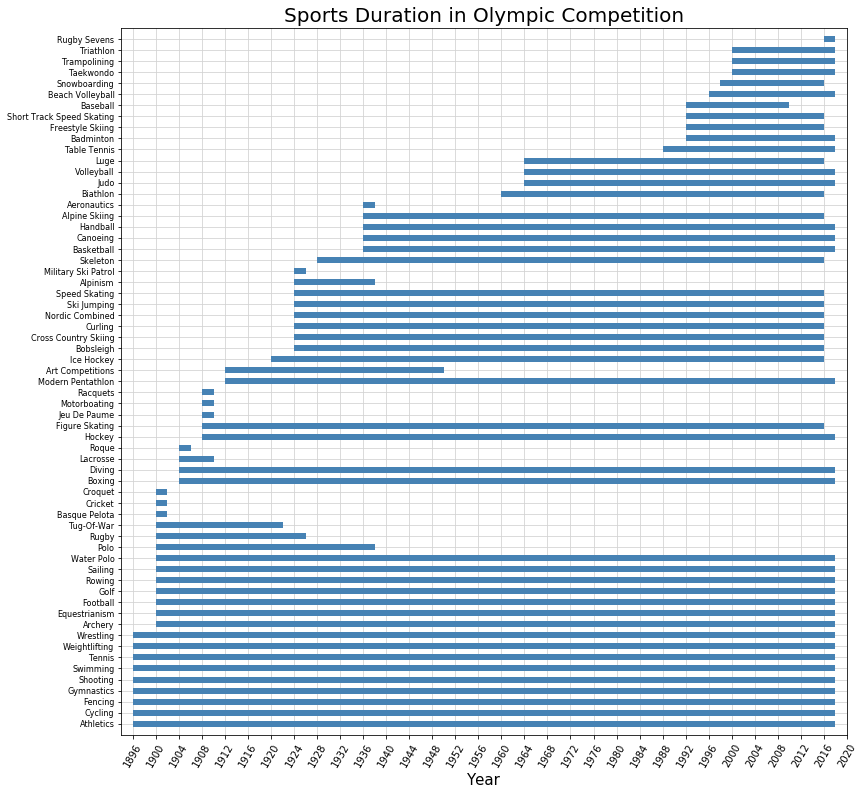

In [323]:
# We now want to make a chart which displays how long each sport maintained its Olympic status

# Start by sorting the first date the sport appeared so the newest sports are on top,
#  and a secondary sort for duration for aesthetics, making the chart flow from shortest lines to longest 
min_and_max_df = min_and_max.sort_values(['min','duration'],ascending=[True, False]).reset_index()

# Now we are ready to make a for-loop to plot each bar (hline) on our graph
plt.figure(0,(13,13))
for i in list(range(0,len(min_and_max_df))):
    plt.hlines(i, min_and_max_df.loc[i]['min'], min_and_max_df.loc[i]['max']+2, color='steelblue', lw=6)

plt.xticks(list(range(1896,2024,4)),rotation=60)
plt.yticks(list(range(0,len(min_and_max_df))), min_and_max_df.Sport, size=8)
plt.xlim(min_and_max_df['min'].min()-2,min_and_max_df['max'].max()+4)
plt.ylim(-1,len(min_and_max_df))
plt.title('Sports Duration in Olympic Competition', size=20)
plt.xlabel('Year', size=15)
plt.grid(color='lightgrey')

plt.savefig("2_plots/14 - Olympic Sport History Over Time.png")

plt.show()

# 5. Conculsions

**png 1:** There are some clear outstanding performers. USA and Russia make up 25% of all medals won in history.


**png 2:** The dominance is even more pronounced when you look at the data by medal-type, with an even more outsized majority of golds going to the Top 3 countries.


**png 3:** This is also confirmed by a geographic map where the "hot spots" for medal success are concentrated in North America, Northern Europe, Russia, East Asia, and Australia
Headline: Average pollution levels in a country do seem to be negatively related to recent medal performance.


**png 4:** History: Russia's journey has been an interesting one. They joined the Olympics for the first time in 1952 and performed exceedingly well. Their sharp jump in 1980 and then decline in 1984 was actually the result of geopolitical situations involving mutual boycotts of successive Olympics with the USA.

**png 5:** Wealth: We can see that a country's GDP has a major impact on their ability to perform at the highest level. 


**png 6:** Health: Our analysis, surprisingly showed that the higher the average obesity rate is in a region, the higher the total number of medals, and this positive correlation was stronger in men than in women. Our hypothesis is that higher GDP leads to higher average obesity rate, and this leads to higher number of male medalists.


**png 7:** Happiness: we found that the happier a region is, the more likely it is to have a larger share of the medals in Olympics history.

**png 8:** Liberty: Although we see some correlation between total female medal share by country versus the women's freedom index, it can most likely be explained by more wealthy countries also having more women's rights. 

**png 9:** Environment: p-value is really close to, but above 0.05. Of course, this is not a "strong relationship"...pollution only explains about 17% of the distribution in medal count.

**png 12:** Variation of height along time for basketball players:
* The height is incrementing over time from 1940 to 1990.
* Height didn't vary as much from 1990 to 2020 and it seems like we hit the critical max for height, It could be that there are not many humans taller than 2m or those who are taller than 2m might not be fit for the game
* The margin for errors is really low which means the trend is real
* The error bars are really large from 1935- 1955 which means that the data might not be accurate and there could be missing Height values

**png 13:** Variation of height along time for gymnasts
* There was an increment in height from 1900-1910 but then it drastically lowered till 1920 and it didn't vary much after that
* The error is really small from 1950 onwards because there are so many gymnasts with such little height difference.
* The error bars are really large before 1920 which means the data might not be accurate until 1920 and there could be missing height values
